In [1]:
import numpy as np
np.seterr(all='raise')
import sys
sys.path.append('../')

from meshmaker.base import Base, Laziness
from meshmaker.model import Model
from meshmaker.mesh import Mesh
from meshmaker.pmesh import ParamMesh, MetaMesh
from meshmaker.tform import TForm
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
#from meshmaker.geometry import batch, slide, loop_offset, loop_normal, loop_contains, isnear, near, loopO
from meshmaker.geometry import batch, slide, isnear, near, loop_normal
from meshmaker.mgl import show, MainShader, EdgeShader, WireShader
from meshmaker.plt import *
from collections import defaultdict
import json
from functools import partial

show = partial(show, programs=[MainShader(), EdgeShader(), WireShader(color=vec3.U().yz())])

In [2]:
from meshmaker.planargraph import planargraph
from meshmaker.plt import *
from functools import reduce

def loop_difference(l1, l2):
    
    # to reduce, take 2, return 1
    # list of positives, list of negatives, list of results
    # this probably just cant be reducible... 
    
    #if others:
    #    return reduce(loop_difference, [l1, l2] + list(others))

    print(l1)
    print(l2)

    l1 = [[p.quant() for p in l] for l in l1]
    l2 = [[p.quant() for p in l] for l in l2]
    segs = [list(slide(l, 2)) for l in (l1 + l2)]
    segs = [x for y in segs for x in y]

    #l1 = [p.quant() for p in l1]
    #l2 = [p.quant() for p in l2]
    #segs = list(slide(l1, 2)) + list(slide(l2, 2))
    
    #segs = [(v, u) for u, v in segs]
    pg = planargraph(segs=segs)
    
    #f, ax = plot()
    #plot_pg(ax, pg, lw=5, col='k')
    #for u, v in segs:
    #    plot_edge(ax, u, v, lw=2, col='r')
    
    _, iloops = pg.polygon()
    parts = []
    for loop in iloops:
        for p in loop:
            if not any(p.inbxy(l, True) for l in l2):
                parts.append(loop)
                break
    return parts

def loop_union(l1, l2):
    l1 = [p.quant() for p in l1]
    l2 = [p.quant() for p in l2]
    segs = list(slide(l1, 2)) + list(slide(l2, 2))
    pg = planargraph(segs=segs)
    union, _ = pg.polygon()
    return [union]

def loop_intersection(l1, l2):
    l1 = [p.quant() for p in l1]
    l2 = [p.quant() for p in l2]
    segs = list(slide(l1, 2)) + list(slide(l2, 2))
    pg = planargraph(segs=segs)
    _, iloops = pg.polygon()
    parts = []
    for loop in iloops:
        for p in loop:
            if (p.inbxy(l1, True) and p.inbxy(l2, True)):
                continue
            else:
                #f, ax = plot()
                #plot_pg(ax, pg)
                #for u, v in segs:
                #    plot_edge(ax, u, v, col='r', lw=1)
                ##plot_loop(ax, l1, col='g')
                ##plot_loop(ax, l2, col='b')
                #plot_point(ax, p, mk='*')
                #raise ValueError('why was i plotting this?')
                break
        else:
            parts.append(loop)
    return parts


def polygon_difference(py1, py2):
    """py2[1] is within negative space by construction"""
    
    pos = py1[0]
    neg = py1[1] + [py2[0]]
    
    if len(neg) > 1:
        neg = reduce(loop_union, neg)
        
    holes = []
    for hole in neg:
        if loop_contains(pos, hole):
            holes.append(hole)
    for hole in holes:
        neg.remove(hole)

    pos = [pos]
    if len(neg) > 0:
        pos = reduce(loop_difference, pos + neg)
        
    pys = []
    for p in pos:
        pys.append((p, [h for h in holes if loop_contains(p, h)]))

    return pys

In [3]:
def autotile(w, h, fill_texture, max_nx=None, max_ny=None):
    
    chunk = [vec3(0, 0, 0), vec3(w, 0, 0), vec3(w, 0, h), vec3(0, 0, h)]
    chunkN = loop_normal(chunk)

    def tiles(loop, chunk_w=1.01, chunk_h=1.01):
        """Chunk a rectangular space into a grid"""
        lw = loop[0].d(loop[ 1])
        lh = loop[0].d(loop[-1])
        nx = int(lw / chunk_w)
        ny = int(lh / chunk_h)
        nx = nx if max_nx is None else min(max_nx, nx)
        ny = ny if max_ny is None else min(max_ny, ny)
        X = (loop[ 1] - loop[0]).nrm()
        Y = (loop[-1] - loop[0]).nrm()
        dx = near((lw - nx * chunk_w) / 2, 0)
        dy = near((lh - ny * chunk_h) / 2, 0)
        
        positions = []
        if nx > 0 and ny > 0:
            for x in range(0, nx):
                x = x * chunk_w + dx
                for y in range(0, ny):
                    y = y * chunk_h + dy
                    positions.append(loop[0] + X * x + Y * y)
        
        if positions:
            assert (nx > 0 and ny > 0)
            return positions, borders(loop, dx, dy, X, Y)
        else:
            return positions, [(loop, ())]

    def borders(loop, dx, dy, X, Y):
        if dx > 0 and dy > 0:
            hole = [loop[0] + X * dx + Y * dy,
                    loop[1] - X * dx + Y * dy,
                    loop[2] - X * dx - Y * dy,
                    loop[3] + X * dx - Y * dy]
            borders = [(loop, (hole, ))]
        elif dx > 0 and dy == 0:
            left = [loop[0].cp(), loop[0] + X * dx,
                    loop[3] + X * dx, loop[3].cp()]
            right = [loop[1] - X * dx, loop[1].cp(),
                     loop[2].cp(), loop[2] - X * dx]
            borders = [(left, ()), (right, ())]            
        elif dx == 0 and dy > 0:
            top = [loop[3] - Y * dy, loop[2] - Y * dy,
                   loop[2].cp(), loop[3].cp()]
            bottom = [loop[0].cp(), loop[1].cp(),
                      loop[1] + Y * dy, loop[0] + Y * dy]
            borders = [(top, ()), (bottom, ())]
        elif dx == 0 and dy == 0:
            borders = []
        else:
            print(dx, dy)
            raise
        return borders

    def g(f):
        """f would normally generate meshes for a rectangular loop ->
        instead presplit its domain into regular chunks and reuse its
        result to cover the original domain, filling in the fat with
        boring meshes"""
        
        cached = f(chunk)
        
        def tiled(rect):
            
            #o = loopO(rect)
            #print()
            #print(rect)
            #print()
            #rect = rect[o:] + rect[:o]

            rectN = loop_normal(rect)
            if chunkN.isnear(rectN):
                q = None
            elif chunkN.isnear(rectN.fp()):            
                q = quat.av(-np.pi, vec3.Z())
            else:
                q = quat.uu(chunkN, rectN)
            
            positions, borders = tiles(rect, w, h)
            
            chunks = [TForm(t=t, q=q) for t in positions]
            for tf in chunks:
                if isinstance(cached, list):
                    cp = cached[0].cp()
                    cached.append(cached.pop(0))
                else:
                    cp = cached.cp()
                tf.add(cp)

            fill = Mesh()
            #fill.af([p.cp().ytrn(0.01) for p in rect])
            for border in borders:
                fill.apy(border)
            fill = Model(meshes={fill_texture: [fill]})
            
            #marker = TForm(t=rect[0].lerp(rect[1], 0.25), models=[Model.cube_model('generic_11', r=0.1)])
            #return TForm(children=(chunks + [marker]), models=[fill])
            
            return TForm(children=chunks, models=[fill])

        return tiled

    return g


@autotile(2, 0.1, 'generic_8', max_ny=1)
def testtile(rect):
    #rect = loop_offset(rect, 0.01)
    texture = 'generic_7'
    mesh = Mesh()
    mesh.af(rect)
    return TForm(models=[Model(meshes={texture: [mesh]})])



loop = [vec3(0, 0, 0), vec3(5, 2, 0), vec3(5, 2, 1), vec3(0, 0, 1)]
show(Base(scene=lambda : testtile(loop)))

Loaded texture: generic_7 (../resources/textures/generics/generic_7.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)


In [4]:
class Seam(Base):
    
    """need a parameterization of a loop for windows"""
    
    @classmethod
    def l2s(cls, loop, m=0):
        s = [cls(u, v) for u, v in slide(loop, 2, m)]
        for i in range(1, len(s)):
            s[i - 1].next = s[i]
        return s[0]
        
    def slide(self, n=2, m=1):
        yield from slide(list(self), n=n, m=m)
        
    def __init__(self, u, v, n=0, du=None, dv=None, **kws):
        du = (v - u).nrm() if du is None else du
        dv = (u - v).nrm() if dv is None else dv
        super().__init__(u=u, v=v, n=n, du=du, dv=dv, **kws)

    def __iter__(self):
        yield from self._iter()
        
    def _iter(self, n=None):
        m = self.n if n is None else n
        if m == 0:
            yield self.u
            #yield self.v
        else:
            yield self.u
            yield from self.u.spline(self.v, self.du, self.dv, m, alpha=1)
        if not (hasattr(self, 'next') and self.next.u.isnear(self.v)):
            yield self.v
        if hasattr(self, 'next'):
            yield from self.next._iter(n=n)

    def _control(self):
        unique = []
        for p in self._iter(n=0):
            if not p in unique:
                unique.append(p)
        return unique

    def trn(self, t):
        t.trnps(self._control())
        return self

    def scl(self, s):
        s.sclps(self._control())
        return self
            
    def rot(self, q):
        q.rot(self._control())
        return self

    def cp(self, root=True):
        cp = Seam(self.u.cp(), self.v.cp(), self.n,
                  self.du.cp(), self.dv.cp())
        if hasattr(self, 'next'):
            cp.next = self.next.cp(False)
            cp.next.u = cp.v
        if root and self._closed():
            cp._last().v = cp.u
        return cp
            
    def _last(self):
        return self.next._last() if hasattr(self, 'next') else self
        
    def _closed(self):
        return self._last().v.isnear(self.u)
        
    def loop(self, n=None):
        points = list(self._iter(n=n))
        if self._closed():
            points.pop(-1)
        return points

In [5]:
def box(w, h, d):
    loop = [vec3(-w / 2, -d, 0), vec3( w / 2, -d, 0),
            vec3( w / 2, -d, h), vec3(-w / 2, -d, h)]
    return loop

In [6]:
class Factory(Base):

    @classmethod
    def lineup(cls, *ags, dx=1, **kws):
        prefabs = cls.scenes(*ags, **kws)
        for i, pf in enumerate(prefabs):
            pf.translate(vec3.X(dx * i))
        return Base(scene=(lambda : TForm(children=prefabs)))
    
    #@factoryfeature
    @classmethod
    def prefabs(cls, *ags, **kws):
        return [cls(**pf) for pf in cls.blueprints(*ags, **kws)]

    @classmethod
    def scenes(cls, *ags, **kws):
        return [pf.scene(*ags, **kws) for pf in cls.prefabs(*ags, **kws)]

    def scene(self, *ags, **kws):
        return TForm(models=self.models(*ags, **kws))
    
    @classmethod
    def blueprints(cls):
        """generate list of prefab dicts"""
        raise NotImplementedError
    
    def models(self, *ags, **kws):
        """generate list of models"""
        raise NotImplementedError
        
        
class PortalFactory(Factory):

    """
    portal prefab: Seam object, sequence of methods
    """
    
    def __init__(self, seam, methods, **kws):
        self.N = loop_normal(seam)
        if self.N.isnear(vec3.Z()):
            self.T = vec3.X()
        else:
            self.T = vec3.Z().crs(self.N).nrm()
        super().__init__(seam=seam, methods=methods, **kws)

    def models(self):
        seam = [p.cp() for p in self.seam]
        models = []
        for method in self.methods:
            model, seam = method(seam)
            if isinstance(model, Model):
                models.append(model)
        return models


class WindowFactory(PortalFactory):
    
    rng = np.random.default_rng(0)
    
    def __init__(self, seam, jamb_width=0.02, jamb_depth=0.04, sill=True, passable=True, **kws):
        
        N = loop_normal(seam)
        X = vec3.Z().crs(N).nrm()                                                                 
        Y = N.crs(X).nrm()                                                                        
        loop = [vec3(p.dot(X), p.dot(Y), 0) for p in seam]
        self.ww = loop[0].d(loop[ 1])
        self.wh = loop[0].d(loop[-1])
        self.wz = loop[0].z
        
        methods = [self.make_jamb]
        if sill:
            methods.insert(0, self.make_sill)
        if not passable:
            methods.append(self.make_pane)
        super().__init__(seam, methods,
                         jamb_width=jamb_width,
                         jamb_depth=jamb_depth, **kws)

    def make_sill(self, loop, **kws):
        w, h, d = 0.01, 0.04, 0.04

        mesh = Mesh()
        mesh.uvs = {}

        u, v = loop[0], loop[1]
        lip = [u - self.T * w, u - self.T * w + self.N * d,
               v + self.T * w + self.N * d, v + self.T * w]
        rim = vec3.nZ(h).trnps([p.cp() for p in lip])
        top = mesh.af(lip)
        bot = mesh.af(rim[::-1])
        sides = mesh.bridge(rim, lip, m=1)
        uvo = vec3.com([mesh.vertices[v] for v in mesh.faces[sides[1]]])
        seams = [edge for seam in mesh.perimeter(sides) for edge in seam]
        mesh.uvs = mesh.unwrap_uvs(sides[1], O=(uvo, vec3.O()),
                                   seams=seams, uvs=mesh.uvs)
        if len(loop) == 4:
        
            '''
            rail = loop[2:]
            rail.insert(0, rail[0] + (rail[0] - rail[1]).nrm() * w)
            rail.append(rail[-1] + (rail[-1] - rail[-2]).nrm() * w)
            rail.reverse()
            rim = [(p + self.N * d) for p in rail] + rail[::-1]
            rim.insert(0, rim.pop(-1))
            print(rail)
            print(rim)
            '''

            u, v = loop[-1], loop[2]
            rim = [u - self.T * w, u - self.T * w + self.N * d,
                   v + self.T * w + self.N * d, v + self.T * w]
        
            lip = vec3.Z(h).trnps([p.cp() for p in rim])
            top = mesh.af(lip)
            bot = mesh.af(rim[::-1])
            #top = mesh.apy((lip, ()))
            #bot = mesh.apy((rim[::-1], ()))
            sides = mesh.bridge(rim, lip, m=1)
            uvo = vec3.com([mesh.vertices[v] for v in mesh.faces[sides[1]]])
            seams = [edge for seam in mesh.perimeter(sides) for edge in seam]
            mesh.uvs = mesh.unwrap_uvs(sides[1], O=(uvo, vec3.O()),
                                       seams=seams, uvs=mesh.uvs)        
        
        return Model(meshes={self.sill_texture: [mesh]}), loop

    def make_jamb(self, loop, **kws):
        """Create reusable model for the window.
        Hide the edges of loop with a mesh"""
        N = loop_normal(loop)
        innerseam = loop_offset(loop, self.jamb_width)

        loops = []
        loops.append((N * (self.jamb_depth / 2)).trnps([p.cp() for p in loop]))
        loops.append(loop_offset(loops[-1], self.jamb_width))
        loops.append((N * (-self.jamb_depth)).trnps([p.cp() for p in loops[-1]]))
        loops.append(loop_offset(loops[-1], -self.jamb_width))
        loops = [list(loop) for loop in zip(*loops)]
        loops.reverse()

        mesh = Mesh()
        patches = mesh.bridges(loops, n=1, m=0)        

        mesh.uvs = {}
        for patch in patches:
            seams = mesh.perimeter(patch)[0]
            patchloop = [mesh.vertices[v] for v in mesh.faces[patch[1]]]
            mesh.uvs = mesh.unwrap_uvs(patch[1],
                O=(vec3.com(patchloop), vec3(0.5, 0.5, 0)), X=self.N,
                seams=seams, uvs=mesh.uvs)
        
        return Model(meshes={self.jamb_texture: [mesh]}), innerseam

    def make_pane(self, loop, **kws):
        mesh = Mesh()
        mesh.fan(vec3.com(loop), loop)
        return Model(meshes={self.pane_texture: [mesh]}), loop

    #@factoryfeature
    @classmethod
    def blueprints(cls):
        bps = [
            dict(seam=vec3.Z(0.20).trnps(box(0.3, 0.6, 0.0)),
                 pane_texture='generic_10',
                 sill_texture='generic_8',
                 jamb_texture='generic_13'),
            dict(seam=vec3.Z(0.40).trnps(box(0.6, 0.4, 0.0)),
                 pane_texture='generic_10',
                 sill_texture='generic_8',
                 jamb_texture='generic_12'),
            dict(seam=vec3.Z(0.20).trnps(box(0.4, 0.6, 0.0)),
                 pane_texture='generic_10',
                 sill_texture='generic_8',
                 jamb_texture='generic_11'),
            dict(seam=vec3.Z(0.01).trnps(box(0.4, 0.8, 0.0)),
                 pane_texture='generic_10',
                 sill_texture='generic_8',
                 jamb_texture='generic_9'),
        ]
        return bps
    
    @classmethod
    def random(cls, door=False, seed=None):
        bps = cls.blueprints()
        rng = cls.rng if seed is None else np.random.default_rng(seed)
        while True:
            if door:
                bp = bps[3]
            else:
                bp = rng.choice(bps[:3])
            yield cls(**bp)

#show(WindowFactory(vec3.Z(0.2).trnps(box(0.2, 0.4, 0.1))))
show(WindowFactory.lineup())

# broken
#show(WindowFactory.random())


Loaded texture: generic_13 (../resources/textures/generics/generic_13.png)
Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_12 (../resources/textures/generics/generic_12.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)
Loaded texture: generic_9 (../resources/textures/generics/generic_9.png)


In [7]:
class WallFactory(Factory):
    
    def __init__(self, windowfactory, wall_texture='generic_1', **kws):
        """ need representation of sub-factory constraints... """
        super().__init__(windowfactory=windowfactory,
                         wall_texture=wall_texture, **kws)

    def place_windows(self, wl, wh, chunk_w, chunk_h, max_nx=None, max_ny=None):
        nx = int(wl / chunk_w)
        nx = min(nx, max_nx) if max_nx is not None else nx
        ny = int(wh / chunk_h)
        ny = min(ny, max_ny) if max_ny is not None else ny
        xs = np.linspace(0, 1, nx * 2 + 1)[1::2]
        ys = np.linspace(0, 1, ny + 1)[:-1]
        placements = []
        for x in xs:
            for y in ys:
                placements.append((x, y, 0))
        return placements

    def make_windows(self, loop, windowfactory, **kws):
        wl = round(loop[0].d(loop[ 1]), 1)
        wh = round(loop[0].d(loop[-1]), 1)
        wallN = loop_normal(loop)
        wallX = vec3.Z().crs(wallN).nrm() * wl
        wallY = wallN.crs(wallX).nrm() * wh
        
        window = windowfactory.models()
        windowN = windowfactory.N
        seam = windowfactory.seam
        window_w = (windowfactory.ww)
        window_h = (windowfactory.wh + windowfactory.wz)
        dN = windowfactory.jamb_depth / 2
        
        if windowN.isnear(wallN):
            q = None
        elif windowN.isnear(wallN.fp()):            
            q = quat.av(-np.pi, vec3.Z())
        else:
            q = quat.uu(windowN, wallN)
        
        nx = getattr(self, 'nx', kws.get('nx', None))
        ny = getattr(self, 'ny', kws.get('ny', None))
                
        chunk_w = 1.2 * window_w
        chunk_h = 1.2 * window_h
        placements = self.place_windows(wl, wh, chunk_w, chunk_h,
                                        max_nx=nx, max_ny=ny)

        windows, holes = [], []
        for u, v, w in placements:
            t = loop[0] + wallX * u + wallY * v + wallN * (w - dN)
            tf = TForm(t=t, q=q, models=window)
            hole = (wallN * dN).trnps(tf.transform(seam))
            windows.append(tf)
            holes.append(hole)
        return windows, holes

    def make_wall(self, loop, holes, **kws):
        try:
            mesh = Mesh()
            mesh.apy(([p.cp() for p in loop],
                      [[p.cp() for p in hole] for hole in holes]))
            mesh.uvs = mesh.unwrap_uvs()
            return [Model(meshes={self.wall_texture: [mesh]})]
        except:
            print('failed to triangulate wall!')
            print((loop, holes))
            print()
            raise
            return []

    def scene(self, loop, **kws):
        if isinstance(self.windowfactory, WindowFactory):
            windowfactory = self.windowfactory
        else:
            windowfactory = next(self.windowfactory)
        windows, holes = self.make_windows(loop, windowfactory, **kws)
        wall = self.make_wall(loop, holes, **kws)
        return TForm(models=wall, children=windows)

#wf = WallFactory(windowfactory=WindowFactory.prefabs()[3])
wf = WallFactory(windowfactory=WindowFactory.random(seed=0))
loop = box(2, 1, -1)
show(Base(scene=lambda : wf.scene(loop, nx=3)))

Loaded texture: generic_1 (../resources/textures/generics/generic_1.png)
Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)
Loaded texture: generic_12 (../resources/textures/generics/generic_12.png)
Loaded texture: generic_13 (../resources/textures/generics/generic_13.png)


17
True


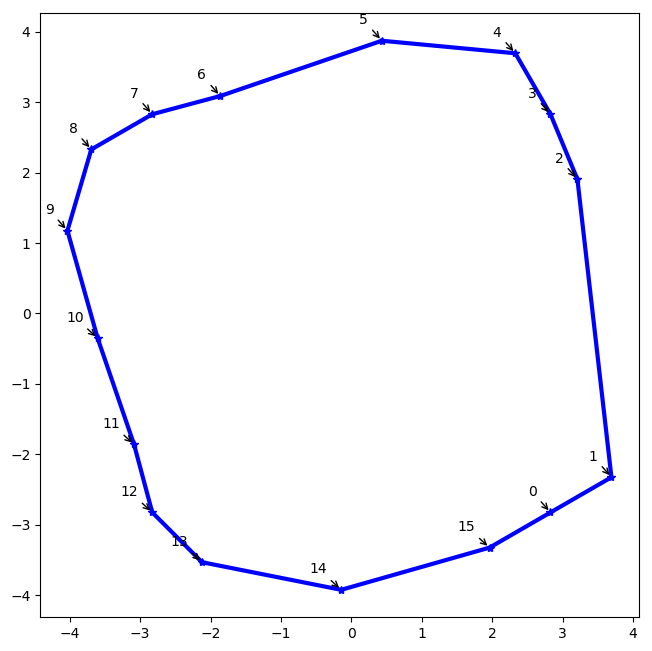

In [8]:
def fp_ex():
    loop = vec3.O().ring(4, 4)
    s = [Seam(u, v) for u, v in slide(loop, 2)]
    for i in range(1, len(s)):
        s[i - 1].next = s[i]

    s[0].n = 2
    s[0].du.rot(quat.rotz(-np.pi / 3))
    s[0].dv.rot(quat.rotz( np.pi / 8))

    s[1].n = 3
    s[1].du.rot(quat.rotz(-np.pi / 3))
    s[1].dv.rot(quat.rotz( np.pi / 12))
    
    s[2].n = 4
    s[2].du.rot(quat.rotz(-np.pi / 3))
    s[2].dv.rot(quat.rotz( np.pi / 12))
    
    s[3].n = 3
    s[3].du.rot(quat.rotz(-np.pi / 4))
    s[3].dv.rot(quat.rotz( np.pi / 6))
    
    print(len(list(s[0])))
    print(list(s[0])[0].isnear(list(s[0])[-1]))
    
    return s[0]
    
s = fp_ex()
f, ax = plot()
plot_loop(ax, s.loop(), mk='*', col='b')
ax.set_aspect(1)
    

In [9]:
class BuildingParameterization(MetaMesh):
    """Responsible for parameterizing control meshes"""
    
    def facegroups(self, mesh):
        groups = defaultdict(list)
        for f, face in mesh:
            N = mesh.face_normals()[f]
            if isnear(N.z, 1):
                groups['top'].append(f)
            elif isnear(N.z, 0):
                groups['side'].append(f)
            elif isnear(N.z, -1):
                groups['bottom'].append(f)
            else:
                groups['top'].append(f)
                #print(N)
                #raise ValueError('ambiguous building face')
        return groups
    
    def parameterize(self, **kws):
        mesh = self.control
        groups = self.facegroups(mesh)
        f2f = mesh.face_rings()
        
        for f in groups['top']:
            mesh.meta[f] = self.make_roof
        
        for f in groups['side']:
            floop = [mesh.vertices[v] for v in mesh.faces[f]]
            if min([p.z for p in floop]) == 0:
                mesh.meta[f] = self.make_wall_f(lobby=True, seed=2)
            else:
                for adj in f2f[f]:
                    if adj in groups['top']:
                        adjloop = [mesh.vertices[v] for v in mesh.faces[adj]]
                        if vec3.com(adjloop).z < vec3.com(floop).z:
                            mesh.meta[f] = self.make_wall_f(lobby=True, seed=3)
                            break
                else:
                    mesh.meta[f] = self.make_wall_f(lobby=False, seed=0)
        
        for f in groups['bottom']:
            mesh.meta[f] = self.make_hang

    def make_roof(self, control, faces):
        f = MetaMesh.textured(texture='generic_8')
        return f(control, faces)
        
    @factoryfeature
    def make_wall_f(self, lobby=False, seed=0):

        if lobby:
            door, nx, ny = True, 1, 1
        else:
            door, nx, ny = False, None, None
        wf = WindowFactory.random(door=door, seed=seed)
        wf = WallFactory(windowfactory=wf)
        scene = lambda rect: wf.scene(loop=rect, nx=2, ny=1)
        rands = lambda rect: [scene(rect) for i in range(8)]
        tiled = autotile(1.99, 0.99, 'generic_7', max_ny=ny)(rands)

        def make_wall(control, faces):
            loops = [[control.vertices[v] for v in control.faces[f]] for f in faces]
            walls = [tiled(loop) for loop in loops]
            return TForm(children=walls)
        
        #make_wall.__name__ += f'_{lobby}_{seed}'
        
        return make_wall
    
    def make_hang(self, control, faces):
        f = MetaMesh.textured(texture='generic_11')
        return f(control, faces)

NameError: name 'factoryfeature' is not defined

In [10]:
class BuildingDesignFactory(Factory):
    """Responsible for generating control mesh prefabs
    
    Constructs buildings bounded by loops in the xy plane.
    Induces interior spaces based on exterior manifold; may induce
    disconnected interior spaces (i.e. contiguous buildings).
    
    """
    
    @classmethod
    def towering(cls, footprint=None, setup=None, n_layers=8):
        """Generate a control mesh"""
        mesh = Mesh()
        patches = []
        
        def build_layer(bot, setup_layer, n=1, m=0):
            top = setup_layer(bot, n=n, m=m)
            patches.append(mesh.bridge(bot.loop(), top.loop()))
            m += 1
            if m < n:
                abv = build_layer(top.cp(), setup_layer, n=n, m=m)
                toploop = top.loop()
                botloop = abv.loop()
                upward   = loop_difference(toploop, botloop)
                for part in upward:
                    try:
                        mesh.apy((part, ()))
                    except:
                        print('a', part)
                downward = loop_difference(botloop, toploop)
                for part in downward:
                    part.reverse()
                    try:
                        mesh.apy((part, ()))
                    except:
                        print('b', part)
            else:
                cap = top.loop()
                try:
                    patch = mesh.apy((cap, ()))
                except:
                    print('c', cap)
            return bot
        
        build_layer(footprint, setup, n=n_layers)
        return mesh

    @classmethod
    def from_seam(cls, seam):
        n_layers = 1 + np.random.choice(4)
        
        def tform(seam, trn, scl, rot):
            control = seam._control()
            com = vec3.com(control)
            #scl = vec3(sx, sy, 1)
            #com.trnps(scl.sclps(com.fp().trnps(control)))
            #seam.scl(vec3(sx, sy, 1))
            seam.trn(com.fp()).scl(scl).rot(rot).trn(com + trn)
        
        def setup(bot, n=1, m=0):
            
            t, s, r = vec3.O(), vec3.U(), quat.O()
            
            if m > 0 and m % 2 == 0:
                s.xtrn(0.2).ytrn(0.2)
                r = quat.rotz(np.pi / 8)
            elif m > 0:
                s.xtrn(-0.2).ytrn(-0.2)
                #r = quat.rotz(np.pi / 12)

            tform(bot, t, s, r)

            top = bot.cp().trn(cls.dZ)
            return top

        return cls.towering(footprint=seam, setup=setup, n_layers=n_layers)

    dZ = vec3.Z() * 1.01
    
    @classmethod
    def simple(cls, bot, n=1, m=0):
        top = bot.cp().trn(cls.dZ)
        return top

    @classmethod
    def setup_layer1(cls, bot, n=1, m=0):
        if m % 2 == 0:
            bot.scl(vec3(1.1, 0.8, 1))
        else:
            bot.scl(vec3(0.8, 1.1, 1))
        top = bot.cp().trn(cls.dZ)
        return top

    @classmethod
    def setup_layer2(cls, bot, n=1, m=0):
        if m % 2 == 0:
            bot.loop(n=0)[m % 3].trn(vec3(1, 1, 0))
            #bot.loop(n=0)[m - 1].trn(vec3(1, 1, 0))
        if m % 3 == 0:
            bot.loop(n=0)[(m + 2) % 3].trn(vec3(-1, 1, 0))
        top = bot.cp().trn(cls.dZ)
        return top
    
    #@factoryfeature
    @classmethod
    def blueprints(cls, **kws):
        """blueprint contains bottom seam, number of layers, and layer setup function"""
        seam = fp_ex()

        bps = [
            dict(setup=cls.setup_layer1, footprint=seam, n_layers=4),
            dict(setup=cls.setup_layer2, footprint=seam, n_layers=8),
        ]
        return bps
        
    def scene(self, **kws):
        control = self.towering(**self.__dict__)
        return BuildingParameterization(control).scene()
    
#designs = BuildingDesignFactory.prefabs()
#show(factory.scene(designs[1]))

#show(BuildingDesignFactory.lineup(dx=15))


In [11]:
def seamtree():
    
    def cramp(seam, edge):
        control = seam._control()
        u, v = control[edge - 1], control[edge]
        n = (v - u).crs(vec3.Z()).nrm()
        along = [c.dot(n) for c in control]
        dn = n * (-0.1 * (max(along) - min(along)))
        u.trn(dn)
        v.trn(dn)
        return seam
        
    dZ = vec3.Z()
    s  = vec3.U()
    
    base = vec3.U().ring(2, 5)
    base = Seam.l2s(base)

    scene = TForm()
    root = scene.add(TForm(base=base))
    for i in range(5):
        base = cramp(base.cp(), i % 3)
        base = cramp(base.cp(), i % 4 + 1)
        root = root.add(TForm(base=base, t=dZ, q=quat.rotz(np.pi / 8), s=s))
    
    mesh = Mesh()
    patches = []

    def bridges(tf):
            
        above = None
        if tf.children:
            for child in tf.children:
                above = bridges(child)

        if hasattr(tf, 'base'):
            base = tf.transform(tf.base.loop())

            base.reverse()
            
            top = (dZ * 0.95).trnps([p.cp() for p in base])

            patches.append(mesh.bridge(base, top))
            
            if above is not None:
                above = [p.cp() for p in above]
                dz = top[0].z - above[0].z
                vec3.Z(dz).trnps(above)
                
                parts = loop_intersection(above, top)
                assert len(parts) == 1
                mesh.bridge((dZ * 0.05).trnps([p.cp() for p in parts[0]]), parts[0])
                
                above = [p.cp().ztrn(-dz) for p in above]
                top = [p.cp().ztrn(-dz) for p in top]
                downward = loop_difference(above, top)
                for part in downward:
                    
                    part.reverse()
                    
                    part.reverse()
                    mesh.apy((part, ()))
            
                above = [p.cp().ztrn(dz) for p in above]
                top = [p.cp().ztrn(dz) for p in top]
                upward   = loop_difference(top, above)
                for part in upward:
                    
                    part.reverse()
                    
                    mesh.apy((part, ()))
                
            else:
                mesh.apy((top, ()))
            
            #mesh.apy((top, ()))
            #mesh.apy((base[::-1], ()))
            
            return base
    
    bridges(scene)
    
    seams = mesh.angle_seams()
    #mesh.uvs = mesh.unwrap_uvs(f=patches[0][0], seams=seams)
    mesh.uvs = {}
    for patch in patches:
        mesh.uvs = mesh.unwrap_uvs(f=patch[0], seams=seams, uvs=mesh.uvs)
    
    return mesh
    
mesh = seamtree()
show(mesh, radius=10, target=vec3.Z(5))

[vec3(0.0355, 0.3972, 6.0000), vec3(-0.6762, -0.9361, 6.0000), vec3(-2.1360, -0.5165, 6.0000), vec3(-2.0011, 0.5332, 6.0000), vec3(-0.8743, 1.0302, 6.0000)]
[vec3(0.1848, 0.3534, 6.0000), vec3(-0.9829, -0.6061, 6.0000), vec3(-2.1710, 0.3403, 6.0000), vec3(-1.6548, 1.6990, 6.0000), vec3(-0.4235, 1.7270, 6.0000)]


AttributeError: 'numpy.float64' object has no attribute 'quant'

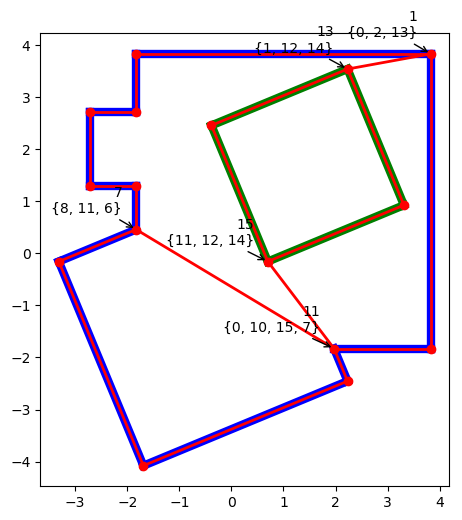

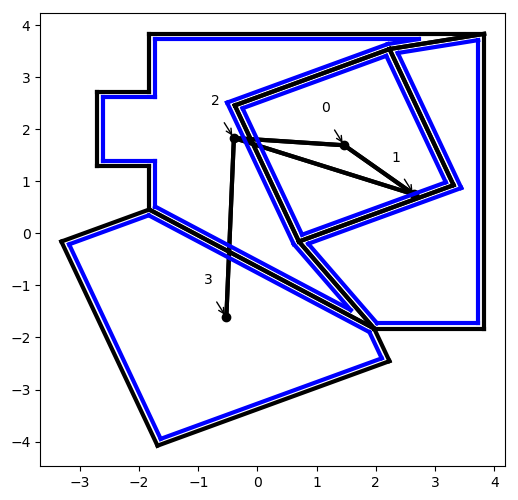

In [17]:
def bg():
    a = quat.rotz(np.pi / 8).rot(vec3(-1,-1, 0).ring(3, 4, True))
    a = loop_union(a, vec3( 1, 1, 0).ring(4, 4, True))[0]
    a = loop_union(a, vec3(-2, 2, 0).ring(1, 4, True))[0]
    b = quat.rotz(np.pi / 8).rot(vec3( 2, 1, 0).ring(2, 4, True))
    
    pg1 = planargraph()
    for l in (a, b):
        for u, v in slide(l, 2):
            pg1.ae(u, v)
    pg1.ae(7, 11)
    pg1.ae(15, 11)
    pg1.ae(13, 1)

    pg2 = pg1.cp()
    for v in filter(None, pg2.vertices):
        v.z += 1.1
        
    #pg1.merge(pg2)
    

    f, ax = plot(figsize=(6, 6))
    plot_loop(ax, a, col='b', lw=6)
    plot_loop(ax, b, col='g', lw=6)
    plot_pg(ax, pg1, col='r', lw=2)
    ax.set_aspect(1)

    
    lg = pg1.loop_graph()
    lg.vertices[1].properties['meta'] = 'foyer'
    f, ax = plot(figsize=(6, 6))
    plot_pg(ax, lg)
    for i, v in enumerate(lg.vertices):
        h = 1.2 if i == 0 else 1.0
        lg.vertices[i].properties['height'] = h
        l = [lg.source.vertices[j] for j in v.properties['loops'][0]]
        plot_loop(ax, l, col='k')
        plot_loop(ax, loop_offset(l, 0.1), col='b')
    
    return pg1, pg2
    
pg1, pg2 = bg()

In [8]:
class NewWallFactory(Base):

    @staticmethod
    def safeloop(al, bl):
        X = (al[ 1] - al[0]).nrm()
        Y = (al[-1] - al[0]).nrm()
        N = X.crs(Y)
        dN = N * ((N.dot(al[0]) - N.dot(bl[1])) / 2)
        sl = [p - dN for p in al]
        sd = bl[1].dot(X) - al[0].dot(X)
        if sd > 0:
            sl[0].trn(X * sd)
            sl[3].trn(X * sd)
        sd = bl[0].dot(X) - al[1].dot(X)
        if sd < 0:
            sl[1].trn(X * sd)
            sl[2].trn(X * sd)
        sd = bl[1].dot(Y) - al[0].dot(Y)
        if sd > 0:
            sl[0].trn(Y * sd)
            sl[1].trn(Y * sd)
        sd = bl[3].dot(Y) - al[2].dot(Y)
        if sd < 0:
            sl[2].trn(Y * sd)
            sl[3].trn(Y * sd)
        return sl
        
    @staticmethod
    def hole(u, v, x, w, h, z):
        T = (v - u).nrm()
        x = u.lerp(v, x) + vec3.Z(z)
        Z = vec3.Z(h)
        hole = [x - T * (w / 2)    , x + T * (w / 2),
                x + T * (w / 2) + Z, x - T * (w / 2) + Z]
        return hole
    
    @classmethod
    def doorhole(cls, sl, x, w=0.4, h=0.8):
        return cls.hole(sl[0], sl[1], x, w, h, 0.02)
    
    @classmethod
    def windowhole(cls, sl, x, w=0.3, h=0.5):
        return cls.hole(sl[0], sl[1], x, w, h, 0.3)
    
    @staticmethod
    def embed(loop, holes):
        N = loop_normal(loop)
        for hole in holes:
            dN = N * (loop[0].dot(N) - hole[0].dot(N))
            dN.trnps(hole)
        return loop, holes

    @staticmethod
    def borders(loop, ldx, rdx, ldy, rdy, X, Y):
        a, b, c, d = loop
        ldY = vec3.Z(ldy)
        rdY = vec3.Z(rdy)
        ldX = (b - a).nrm() * ldx
        rdX = (b - a).nrm() * rdx
        chunks = []
        if ldx > 0:
            chunks.append([a + ldY, a + ldY + ldX, d - rdY + ldX, d - rdY])
            if ldy > 0:
                chunks.append([a.cp(), a + ldX, a + ldY + ldX, a + ldY])
            if rdy > 0:
                chunks.append([d - rdY, d - rdY + ldX, d + ldX, d.cp()])
        if rdx > 0:
            chunks.append([b + ldY - rdX, b + ldY, c - rdY, c - rdY - rdX])
            if ldy > 0:
                chunks.append([b - rdX, b.cp(), b + ldY, b + ldY - rdX])
            if rdy > 0:
                chunks.append([c - rdY - rdX, c - rdY, c.cp(), c - rdX])
        if ldy > 0:
            chunks.append([a + ldX, b - rdX, b - rdX + ldY, a + ldX + ldY])
        if rdy > 0:
            chunks.append([d + ldX - rdY, c - rdX - rdY, c - rdX, d + ldX])
        return chunks
        
    @staticmethod
    def tiles(loop, 
              chunk_w=1.01, chunk_h=1.01, 
              x_align=1.0, y_align=1.0, 
              max_nx=None, max_ny=None):
        """Chunk a rectangular space into a grid"""
        assert (x_align >= 0.0 and x_align <= 2.0)
        assert (y_align >= 0.0 and y_align <= 2.0)
        lw = loop[0].d(loop[ 1])
        lh = loop[0].d(loop[-1])
        nx = int(lw / chunk_w)
        ny = int(lh / chunk_h)
        nx = nx if max_nx is None else min(max_nx, nx)
        ny = ny if max_ny is None else min(max_ny, ny)
        X = (loop[ 1] - loop[0]).nrm()
        Y = (loop[-1] - loop[0]).nrm()
        dx = near((lw - nx * chunk_w) / 2, 0)
        dy = near((lh - ny * chunk_h) / 2, 0)
        positions = []
        if nx > 0 and ny > 0:
            for x in range(0, nx):
                x = x * chunk_w + dx * x_align
                for y in range(0, ny):
                    y = y * chunk_h + dy * y_align
                    positions.append(loop[0] + X * x + Y * y)
        return positions, (dx, dy, X, Y)
        
    @staticmethod
    def fliploop(loop):
        return [loop[1].cp(), loop[0].cp(), loop[3].cp(), loop[2].cp()]
        
    def tileable(self, w, h, d, ltex='generic_12', rtex='generic_13',
                 window=False, door=False, **kws):
        l = [vec3(0,-d, 0), vec3(w,-d, 0), vec3(w,-d, h), vec3(0,-d, h)]
        r = [vec3(w, d, 0), vec3(0, d, 0), vec3(0, d, h), vec3(w, d, h)]
        N = kws.get('N', vec3.nY())

        if door:
            lh = [self.doorhole(l, 0.4)]
            rh = [self.fliploop(self.doorhole(r, 0.6))]
        elif window:
            lh = [self.windowhole(l, 0.4)]
            rh = [self.fliploop(self.windowhole(r, 0.6))]
        else:
            lh, rh = [], []
        
        meshes = defaultdict(list)
        
        if ltex:
            ml = Mesh()
            ml.apy((l, lh))
            meshes[ltex].append(ml)
        if rtex:
            mr = Mesh()
            mr.apy((r, rh))
            meshes[rtex].append(mr)
        mm = Mesh()
        for lhole, rhole in zip(lh, rh):
            mm.bridge(lhole, rhole)
        meshes['generic_11'].append(mm)
        
        #mesh.uvs = mesh.unwrap_uvs(seams=mesh.angle_seams())
        return TForm(models=[Model(meshes)], chunk_N=N)
        
    def _get_cached(self, chunk_w=1, chunk_h=1, chunk_d=0.1):
        def tile(**kws):
            tf = self.tileable(chunk_w, chunk_h, chunk_d / 2, **kws)
            tf.chunk_w = chunk_w
            tf.chunk_h = chunk_h
            tf.chunk_d = chunk_d
            return tf
        itex, etex = 'generic_2', 'generic_13'
        cached = {
            'i_1' : tile(ltex=itex, rtex=None),
            'i__1' : tile(ltex=itex, rtex=None, window=True),
            'e_1' : tile(ltex=etex, rtex=None),
            'ie_1': tile(ltex=itex, rtex=etex, window=True),
            'ii_1': tile(ltex=itex, rtex=itex, door=True),
            'ee_1': tile(ltex=etex, rtex=etex),
                }
        return cached
        
    def metas(self, cached=None, x_align=1.0, y_align=0.0, max_nx=None, max_ny=None,
              fill_texture='generic_4', debug=True, debug_texture='generic_8'):        
        
        def metaf(control, faces):
            if len(faces) == 1:
                af, = faces
                al = [control.vertices[v] for v in control.faces[af]]
                bl = None
                sl = [p.cp().trn(loop_normal(al) * -(cached.chunk_d / 2)) for p in al]
            elif len(faces) == 2:
                af, bf = faces
                al = [control.vertices[v] for v in control.faces[af]]
                bl = [control.vertices[v] for v in control.faces[bf]]
                sl = self.safeloop(al, bl)
            
            positions, (dx, dy, X, Y) = self.tiles(sl, cached.chunk_w, cached.chunk_h,
                                                   x_align, y_align, max_nx, max_ny)
            borders = []
            if positions:
                sN = loop_normal(sl)
                if cached.chunk_N.isnear(sN):
                    q = None
                elif cached.chunk_N.isnear(sN.fp()):            
                    q = quat.av(-np.pi, vec3.Z())
                else:
                    q = quat.uu(cached.chunk_N, sN)
                chunks = [TForm(t=t, q=q) for t in positions]
                for tf in chunks:
                    tf.add(cached.cp())
                if al:
                    ldx =     (x_align) * dx + near((X.dot(sl[ 0]) - X.dot(al[ 0])), 0)
                    rdx = (2 - x_align) * dx + near((X.dot(al[ 1]) - X.dot(sl[ 1])), 0)
                    ldy =     (y_align) * dy + near((Y.dot(sl[ 0]) - Y.dot(al[ 0])), 0)
                    rdy = (2 - y_align) * dy + near((Y.dot(al[-1]) - Y.dot(sl[-1])), 0)
                    borders.extend(self.borders(al, ldx, rdx, ldy, rdy, X, Y))
                if bl:
                    X = X.fp()
                    ldx = (2 - x_align) * dx + near((X.dot(sl[ 1]) - X.dot(bl[ 0])), 0)
                    rdx =     (x_align) * dx + near((X.dot(bl[ 1]) - X.dot(sl[ 0])), 0)
                    ldy =     (y_align) * dy + near((Y.dot(sl[ 0]) - Y.dot(bl[ 0])), 0)
                    rdy = (2 - y_align) * dy + near((Y.dot(bl[-1]) - Y.dot(sl[-1])), 0)
                    borders.extend(self.borders(bl, ldx, rdx, ldy, rdy, X, Y))
            else:
                chunks  = []
                if al:
                    borders.append(al)
                if bl:
                    borders.append(bl)

            fill = Mesh()
            for border in borders:
                fill.af(border)
            fill = Model(meshes={fill_texture: [fill]})
            
            if debug:
                if sl is not None:
                    dZ = vec3.Z(0)
                    pl = self.fliploop(sl)
                    dbg = Mesh()
                    dbg.af(dZ.trnps(vec3(1, 1, 1).sclps([p.cp() for p in sl])))
                    dbg.af(dZ.trnps(vec3(1, 1, 1).sclps([p.cp() for p in pl])))
                    dbg = Model(meshes={debug_texture: [dbg]})
                    chunks.append(TForm(models=[dbg]))
                    
            #chunks.append(TForm(t=sl[0].lerp(sl[1], 0.5), q=q,
            #                    models=[Model.cube_model('generic_8', r=0.2)]))
            
            return TForm(children=chunks, models=[fill])

        return metaf
    
def test():
    d = 0.2
    a = [vec3(-0.2,-d,-0.2), vec3(1.8,  -d,-0.2), vec3(1.8,-d, 1), vec3(-0.2,  -d, 1)]
    b = [vec3( 1.2, 0.0, 0), vec3(  0, 0.0,   0), vec3(0, 0.0, 2), vec3( 1.2, 0.0, 2)]
    w = dict(loops=[a, b], doors=[], exterior=False)
    wf = NewWallFactory()
    
    tiles = wf._get_cached(1, 1, d)

    samples = []

    mesh = Mesh()
    meta = wf.metas(tiles['ie_1'])
    mesh.af(a, meta=meta)
    mesh.af(b, meta=meta)
    samples.append(mesh)

    mesh = Mesh()
    meta = wf.metas(tiles['ie_1'])
    mesh.af(b, meta=meta)
    mesh.af(a, meta=meta)
    samples.append(mesh)

    mesh = Mesh()
    meta = wf.metas(tiles['ii_1'])
    mesh.af(a, meta=meta)
    mesh.af(b, meta=meta)
    samples.append(mesh)

    mesh = Mesh()
    meta = wf.metas(tiles['ii_1'])
    mesh.af(b, meta=meta)
    mesh.af(a, meta=meta)
    samples.append(mesh)

    mesh = Mesh()
    meta = wf.metas(tiles['i_1'])
    mesh.af(a, meta=meta)
    samples.append(mesh)

    mesh = Mesh()
    meta = wf.metas(tiles['i_1'])
    mesh.af(b, meta=meta)
    samples.append(mesh)
    
    mesh = Mesh()
    meta = wf.metas(tiles['e_1'])
    mesh.af(a, meta=meta)
    samples.append(mesh)

    mesh = Mesh()
    meta = wf.metas(tiles['e_1'])
    mesh.af(b, meta=meta)
    samples.append(mesh)
    
    samples = [MetaMesh(mesh).scene() for mesh in samples]
    for i, tf in enumerate(samples):
        tf.translate(vec3.X(2.5 * i))
    show(samples)
    
test()

Loaded texture: generic_13 (../resources/textures/generics/generic_13.png)
Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_2 (../resources/textures/generics/generic_2.png)
Loaded texture: generic_4 (../resources/textures/generics/generic_4.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)


In [9]:
def mark_door(lg, seam, w, every=False):
    ps = lg.source.vertices
    n = len(seam)
    lengths = np.zeros((n, ))
    P = np.zeros((n, ))
    for k, (x, y) in enumerate(seam):
        lengths[k] = ps[x].d(ps[y])
        if lengths[k] > w:
            P[k] += 1
    doors = []
    if P.size > 0 and P.max() > 0:
        if every:
            ldoor = list(np.where(P > 0)[0])
            rdoor = [seam.index(seam[ld][::-1]) for ld in ldoor]
            x = 0.5
            for ld, rd in zip(ldoor, rdoor):
                doors.append((ld, x))
                doors.append((rd, 1 - x))
        else:
            ldoor = np.random.choice(n, p=(P / P.sum()))
            rdoor = seam.index(seam[ldoor][::-1])
            x = 0.5
            doors.append((ldoor, x))
            doors.append((rdoor, 1 - x))
    return doors


def mark_window(lg, seam, w=0.01):
    return mark_door(lg, seam, w=w, every=True)
    

def mark_doors(lg, doorwidth=0.01, windowwidth=0.01):
    ps = lg.source.vertices
    for i, v in enumerate(lg.vertices):
        v.properties['boundary'] = sorted(list(v.properties['boundary']), key=min)
        if v.properties.get('meta') == 'foyer':
            v.properties['doors'] = mark_door(lg, v.properties['boundary'], w=doorwidth)
        else:
            v.properties['windows'] = mark_window(lg, v.properties['boundary'], w=windowwidth)
        for j in lg.rings[i]:
            key = (i, j) if i < j else (j, i)
            _, _, e = lg.edges[lg.edge_lookup[key]]
            e['seam'] = sorted(list(e['seam']), key=min)
            e['doors'] = mark_door(lg, e['seam'], w=doorwidth, every=False)


def get_boundary(lg):
    ps = lg.source.vertices
    edges = []
    for i, v in enumerate(lg.vertices):
        v.properties['boundary'] = sorted(list(v.properties['boundary']), key=min)
        b = v.properties.get('boundary')
        edges.extend([(ps[n], ps[m]) for n, m in b])
    pg = planargraph(segs=edges)
    boundary, _ = pg.loops()
    boundary = [lg.source.fv(pg.vertices[i]) for i in boundary]
    return boundary

            
def lgwalls(lg, wallwidth=0.1, doorwidth=1, windowwidth=1):
    mark_doors(lg, doorwidth=doorwidth, windowwidth=windowwidth)
    
    cppy = lambda py: ([p.cp() for p in py[0]], [[p.cp() for p in h] for h in py[1]])
    cplp = lambda lp: [p.cp() for p in lp]
    
    floors = {}
    walls  = {}
    crowns = {}

    boundary = get_boundary(lg)
    boundarye = list(slide(boundary, 2))
    boundaryps = loop_offset([lg.source.vertices[i] for i in boundary], -wallwidth)
    
    # loop over loop graph vertices (rooms)
    for i, v in enumerate(lg.vertices):
        dZ = vec3.Z(v.properties['height'])
        
        loop = v.properties['loops'][0]
        loope = list(slide(list(loop), 2))
        ob = [lg.source.vertices[j] for j in loop]
        ib = loop_offset(ob, wallwidth)
        
        vmeta = v.properties.get('meta')
        if vmeta == 'shaft-bottom':
            fpys, cpys = [(ib, ())], []
        elif vmeta == 'shaft-middle':
            fpys, cpys = [], []
        elif vmeta == 'shaft-top':
            fpys, cpys = [], [(dZ.trnps(cplp(ib)), ())]
        else:
            fpys, cpys = [(ib, ())], [(dZ.trnps(cplp(ib)), ())]
        floors[i] = fpys
        crowns[i] = cpys

        windows = v.properties.get('windows')
        windowi, windowx = zip(*windows) if windows else ((), ())
        
        doors = v.properties.get('doors')
        doori, doorx = zip(*doors) if doors else ((), ())

        # loop over seams between this vertex and the void
        for k, (n, m) in enumerate(v.properties.get('boundary', ())):
            n, m = (m, n) if ([n, m] in boundarye) else (n, m)
            
            x, y = ib[loop.index(n)], ib[loop.index(m)]
            int_loop = [x, y, y + dZ, x + dZ]
            x, y = boundaryps[boundary.index(m)], boundaryps[boundary.index(n)]
            ext_loop = [x, y, y + dZ, x + dZ]
            
            wall = dict(loops=[int_loop, ext_loop], windows=[], doors=[], exterior=True)
            #if k in windowi:
            #    x_ = windowx[windowi.index(k)]
            #    wall['windows'].append(x_)
            if k in doori:
                x_ = doorx[doori.index(k)]
                wall['doors'].append(x_)

            walls[(n, m)] = wall
            walls[(m, n)] = wall # exterior wall here

        # loop over seams between this vertex and its ring
        for j in lg.rings[i]:
            key = (i, j) if i < j else (j, i)
            _, _, e = lg.edges[lg.edge_lookup[key]]

            seam, doors = e['seam'], e.get('doors')
            doori, doorx = ((), ()) if doors is None else zip(*doors)
            
            # loop over the edges in the seam
            for k, (n, m) in enumerate(seam):
                if [m, n] in loope:
                    
                    x, y = ib[loop.index(n)], ib[loop.index(m)]
                    int_loop = [x, y, y + dZ, x + dZ]
                    
                    wall = walls.get((m, n), dict(loops=[], doors=[], exterior=False))
                    wall['loops'].append(int_loop)
                    if n < m and k in doori:
                        x_ = doorx[doori.index(k)]
                        wall['doors'].append(x_)
                    
                    walls[(n, m)] = wall

    # capture the polygon defined by the top seams
    #crown  = ([(p + dZ) for p in boundaryps],
    #          {i: [(p + dZ) for p in f] for i, (f, hs) in floors.items()})
    
    crown  = (dZ.trnps(cplp(boundaryps)),
              {i: pys for i, pys in crowns.items()})
              #{i: [dZ.trnpy(cppy(py)) for py in pys] for i, pys in floors.items()})
    floors = ([p.cp() for p in boundaryps],
              {i: pys for i, pys in floors.items()})
                
    return floors, walls, crown


def control_meshes(walls, floors, crowns):
    meshes = []

    for i, parts in floors[1].items():
        mesh = Mesh()
        for part in parts:
            mesh.apy(part)
        meshes.append(mesh)
    
    for i, parts in crowns[1].items():
        mesh = Mesh()
        for part in parts:
            mesh.apy((part[0][::-1], [h[::-1] for h in part[1]]))
        meshes.append(mesh)

    wf = NewWallFactory()
    tiles = wf._get_cached(1, 1, 0.2)
    
    keys = [(n, m) for n, m in walls if n < m]
    for n, m in keys:
        a, b = walls.get((n, m)), walls.get((m, n))

        if a.get('exterior'):
            if a.get('doors'):
                tile = tiles['ii_1']
                max_nx = 1
            else:
                tile = tiles['ie_1']
                max_nx = None
        else:
            tile = tiles['ii_1']
            if a.get('doors'):
                max_nx = 1
            else:
                max_nx = 0

        a, b = a['loops']
        mesh = Mesh()
        meta = wf.metas(tile, max_nx=max_nx, debug=False)
        mesh.af(a, meta=meta)
        mesh.af(b, meta=meta)
        meshes.append(mesh)
            
    #print(f'crown={crown}')
    #mesh = Mesh()
    #mesh.apy(crown, meta=ParamMesh.textured(texture='generic_8'))
    #meshes.append(mesh)
        
    return meshes


def pginterior(pgs, wallwidth=0.1):
    lgs = [pg.loop_graph() for pg in pgs]
    lgs[0].vertices[1].properties['meta'] = 'foyer'
    lgs[0].vertices[0].properties['meta'] = 'shaft-bottom'
    lgs[1].vertices[0].properties['meta'] = 'shaft-top'
    
    h = 1.0
    s = 0.1
    
    for lg in lgs:
        f, ax = plot()
        plot_pg(ax, lg)
        for i, v in enumerate(lg.vertices):
            
            if 'shaft' in v.properties.get('meta', ''):
                height = h + s
            else:
                height = h
            
            lg.vertices[i].properties['height'] = height
            l = [lg.source.vertices[j] for j in v.properties['loops'][0]]
            plot_loop(ax, l, col='k')
            plot_loop(ax, loop_offset(l, 0.1), col='b')
    
    layers = [lgwalls(lg) for lg in lgs]
    #walls, floors, crown = lgwalls(lg, wallwidth=wallwidth)
    meshes = [control_meshes(walls, floors, crown) for floors, walls, crown in layers]
    
    for (_, _, x), (y, _, _) in slide(layers, 2, 1):
        mesh = Mesh()
        #mesh.bridge(x[0], y[0], meta=ParamMesh.textured(texture='generic_10'))
        print(x[0])
        print(y[0])
        mesh.bridge(x[0], y[0])
        meshes.append([mesh])

    return [x for y in meshes for x in y]


controls = pginterior([pg1, pg2])
show(Base(scene=lambda : TForm(children=[MetaMesh(c).scene() for c in controls])))

NameError: name 'pg1' is not defined

In [ ]:
class Fence(MetaMesh):
    
    def __init__(self, path, **kws):
        control = self.make_control(path, **kws)
        super().__init__(control, **kws)

    def make_control(self, path):
        C = Mesh()
        
        h = 1
        w = 0.02

        z = vec3.Z(h)
        
        f, ax = plot(figsize=(6, 6))
        
        loop = path.loop()

        plot_loop(ax, loop, mk='*')
        
        gloop = [p.xy() for p in loop]
        oloop = [p.ztrn(q.z) for p, q in zip(loop_offset(gloop,-w), loop)]
        iloop = [p.ztrn(q.z) for p, q in zip(loop_offset(gloop, w), loop)]
        loops = []
        for u, v in zip(iloop, oloop):
            loops.append([v, v + z, u + z, u])
        loops.reverse()
        C.bridges(loops, n=1, m=(0 if path._closed() else 1))
            
        #for loop in loops:
        #    C.af(loop)
        
        return C


seam = [vec3(0, 0, 0), vec3(1, 1, 0),
        vec3(1, 2, 1), vec3(0, 2, 1)]

show(Fence(Seam.l2s(seam, m=0)))

In [9]:
class Stairs(MetaMesh):
    
    def __init__(self, **kws):
        control = self.make_control(**kws)
        self.stepheight = 0.1
        self.debug = False
        super().__init__(control,
                         texture='generic_10',
                         debugtexture='generic_8',
                         **kws)

    def rail(self, seam):
        A, B = seam[0], seam[-1]
        N = (A - B).xy().nrm()
        #T = vec3.Z().crs(N).nrm()
        Z = vec3.Z(0.3)

        a, b, c = A.cp(), A - N * 0.1, B - vec3.Z(0.1)
        d, e, f = B + Z, B + Z + N * 0.1, A + Z
        
        #loop = (T * 0.02).trnps([a, b, c, d, e, f])
        loop = [a, b, c, d, e, f]
        return loop
        #return Prism.from_loop(loop, 0.04).control

        mesh.af((a, b, f))
        mesh.af((b, c, e, f))
        mesh.af((c, d, e))
        
    def flight(self, a, b, c, d):
        r = a.d(d)
        z = d.z - a.z
        n = int(abs(z) / self.stepheight)
        lb = a.line(d, n, True)
        rb = b.line(c, n, True)
        h = lb[1].d(lb[0])
        z = lb[1].z - lb[0].z
        t = np.arccos(z / h)
        dX = vec3.Z().crs(a - b).nrm() * (h * np.sin(t))

        steps = Mesh()
        steps.uvs = {}
        lrail, rrail = [], []
        for (aa, bb), (cc, dd) in slide(list(zip(lb, rb)), 2, 1):
            lrail.append(cc + dX); lrail.append(cc);
            rrail.append(dd + dX); rrail.append(dd);
            front = steps.af([aa, bb, dd + dX, cc + dX])
            top   = steps.af([cc + dX, dd + dX, dd, cc])
            seams = steps.perimeter((front, top))
            steps.unwrap_uvs(top, O=(cc + dX, vec3.O()),
                             seams=seams, uvs=steps.uvs)
        lrail.insert(0, lb[0].cp())
        rrail.insert(0, rb[0].cp())
        
        lrail = self.rail(lrail)
        rrail = self.rail(rrail)
        back  = [rrail[1], lrail[1], lrail[2], rrail[2]]
        steps.af(back)
        
        railN = loop_normal(lrail)
        
        lrail = Mesh.prism(lrail, 0.04)
        lrail = TForm(t=railN * -0.02, models=[Model(meshes={self.texture: [lrail]})])
        rrail = Mesh.prism(rrail, 0.04)
        rrail = TForm(t=railN *  0.02, models=[Model(meshes={self.texture: [rrail]})])
            
        '''
        for p, q in zip(lb[::-1], rb[::-1]):
            lrail.append(p - vec3.Z(z))
            rrail.append(q - vec3.Z(z))
        lrail[-1].ztrn(z)
        rrail[-1].ztrn(z)
        steps.apy((lrail      , ()))
        steps.apy((rrail[::-1], ()))

        back = [lrail[2 * n + 2],
                rrail[2 * n + 2], 
                rrail[-2], lrail[-2]]
        steps.af(back)
        '''
        #return TForm(models=[Model(meshes={self.texture: [steps, lrail, rrail]})])
        return TForm(models=[Model(meshes={self.texture: [steps]})],
                     children=[lrail, rrail])
    
    
    
    def steps(self, control, faces):
        flights = TForm()
        for f in faces:
            a, b, c, d = [control.vertices[v] for v in control.faces[f]]
            flight = self.flight(a, b, c, d)
            flights.add(flight)
        return flights
    
    def cast(self, u, v, z, r=1.0):
        N = vec3.Z().crs(v - u).nrm()
        x = r * z
        a = v + N * x - vec3.Z(z)
        b = u + N * x - vec3.Z(z)
        return [a, b, u.cp(), v.cp()]
    
    def make_control(self, **kws):
        a = vec3.O(   ).ring(5, 4, True)
        b = vec3.Z(1.0).ring(5, 4, True)
        c = vec3.Z(1.0).ring(2, 4, True)
        d = vec3.Z(0.9).ring(5, 4, True)
        e = vec3.Z(0.9).ring(2, 4, True)
        
        loops = [self.cast(c[0].lerp(c[1], 0.2),
                           c[0].lerp(c[1], 0.6),
                           b[0].z - a[0].z)]

        #show(Fence(Seam.l2s(seam, m=0)))
        
        mesh = Mesh()
        mesh.af(a, meta=self.textured(texture='generic_4'))
        mesh.apy((b, (c, )), meta=self.textured(texture='generic_4'))
        mesh.apy((d[::-1], (e[::-1], )), meta=self.textured(texture='generic_4'))
        mesh.bridge(d, b)
        mesh.bridge(c, e)
        
        for i, loop in enumerate(loops):
            mesh.af(loop, meta=self.steps)
            #mesh.af(loop, meta=self.textured(texture='generic_10'))
        
        #mesh.af(left)
        #mesh.af(right[::-1])
        #mesh.af(front)
        #mesh.bridge(l, r)
        return mesh
    
show(Stairs(), background=vec3(1, 1, 1))

Loaded texture: generic_10 (../resources/textures/generics/generic_10.png)
Loaded texture: generic_4 (../resources/textures/generics/generic_4.png)


# if a building has an interior, its exterior mesh is created after the interior, because windows/doows are positioned while designing the interior

# TRASHLINE

In [ ]:
a = vec3.O().ring(1.5, 5)
b = vec3.U().ztrn(-1).ring(1.5, 5)
c = loop_offset(a, 0.25)
d = loop_offset(b, 0.25)
e = vec3(0.5, 2.0, 1).sclps([p.cp() for p in a])
g = vec3(0.25, 1.0, 1).sclps([p.cp() for p in a])
h = vec3.X(-2).ring(1, 4)
i = vec3.X(2).ring(1, 4)
j = vec3.O().ring(3, 4, True)
k = vec3.U().ztrn(-1).ring(2, 4, True)
x = vec3(-1,-1, 0).ring(0.5, 4, True)
y = vec3( 1, 1, 0).ring(0.5, 4, True)
z = vec3( 0, 0, 0).ring(2, 4, True)

figsize = (4, 4)

In [ ]:
def test_loop_difference(a, b, *others):
    f, ax = plot(figsize=figsize)
    c = loop_difference(a, b, *others)
    for d in c:
        plot_loop(ax, d, col='g', fill='m')
    for _ in a:
        plot_loop(ax, _, lw=1, ls='--', col='r')
    for _ in b:
        plot_loop(ax, _, lw=1, ls='--', col='b')
    
test_loop_difference([z], [x])
#test_loop_difference(z, x, y)
#test_loop_difference(j, k, a, b)

In [ ]:
def pydiff_test(a, b):
    f, ax = plot(figsize=figsize)
    for py in polygon_difference(a, b):
        plot_polygon(ax, py, col='g', fill='y')
    plot_polygon(ax, a, lw=1, ls='--', col='r')
    plot_polygon(ax, b, lw=1, ls='--', col='b')
    
pydiff_test((a, []), (e, []))
pydiff_test((a, []), (e, [g]))
pydiff_test((a, [c]), (b, [d]))
pydiff_test((a, [c]), (b, []))
pydiff_test((a, []), (b, []))
pydiff_test((a, []), (c, []))
pydiff_test((a, []), (d, []))

In [ ]:
def test_loop_union(a, b):
    f, ax = plot(figsize=figsize)
    c = loop_union(a, b)
    for d in c:
        plot_loop(ax, d, col='g', fill='m')
    plot_loop(ax, a, lw=1, ls='--', col='r')
    plot_loop(ax, b, lw=1, ls='--', col='b')

test_loop_union(h, i)

In [ ]:
@autotile(1.4, 1.2, 'generic_4')
def doublewindow(rect):
    
    #ww, wh, wz, wd = 0.3, 0.6, 0.2, 0.04
    #wf = WindowFactory(ww, wh, wz, wd)
    #window = wf.scene()
    
    #wall = WallFactory(_loop=rect, ny=1, nx=2).scene()
    wall = WallFactory.scenes(loop=rect, ny=1, nx=None)
    
    return wall
    

loop = [vec3(0, 0, 0), vec3(5, 0, 0), vec3(5, 0, 4.5), vec3(0, 0, 4.5)]
print(loop)

show(Base(scene=lambda : doublewindow(loop)))

In [ ]:
from meshmaker.plt import *
from meshmaker.delaunay import triangulation

#py = ([vec3(1.0000, -1.0000, 4.0000), vec3(1.0000, 1.0000, 4.0000), vec3(-1.0000, 1.0000, 4.0000), vec3(-1.0000, -1.0000, 4.0000)], [[vec3(0.8000, -0.9000, 4.0000), vec3(0.8000, -0.6000, 4.0000), vec3(0.2000, -0.6000, 4.0000), vec3(0.2000, -0.9000, 4.0000)], [vec3(-0.2000, -0.9000, 4.0000), vec3(-0.2000, -0.6000, 4.0000), vec3(-0.8000, -0.6000, 4.0000), vec3(-0.8000, -0.9000, 4.0000)], [vec3(0.8000, -0.4000, 4.0000), vec3(0.8000, -0.1000, 4.0000), vec3(0.2000, -0.1000, 4.0000), vec3(0.2000, -0.4000, 4.0000)], [vec3(-0.2000, -0.4000, 4.0000), vec3(-0.2000, -0.1000, 4.0000), vec3(-0.8000, -0.1000, 4.0000), vec3(-0.8000, -0.4000, 4.0000)], [vec3(0.8000, 0.1000, 4.0000), vec3(0.8000, 0.4000, 4.0000), vec3(0.2000, 0.4000, 4.0000), vec3(0.2000, 0.1000, 4.0000)], [vec3(-0.2000, 0.1000, 4.0000), vec3(-0.2000, 0.4000, 4.0000), vec3(-0.8000, 0.4000, 4.0000), vec3(-0.8000, 0.1000, 4.0000)], [vec3(0.8000, 0.6000, 4.0000), vec3(0.8000, 0.9000, 4.0000), vec3(0.2000, 0.9000, 4.0000), vec3(0.2000, 0.6000, 4.0000)], [vec3(-0.2000, 0.6000, 4.0000), vec3(-0.2000, 0.9000, 4.0000), vec3(-0.8000, 0.9000, 4.0000), vec3(-0.8000, 0.6000, 4.0000)]])
#py = ([vec3(-2.0000, -1.0000, 1.0000), vec3(1.0000, 2.0000, 1.0000), vec3(-1.0000, 2.0000, 1.0000), vec3(-2.0000, 1.0000, 1.0000)], [[vec3(-1.9167, -0.8000, 1.0000), vec3(-1.6167, -0.8000, 1.0000), vec3(-1.6167, -0.2000, 1.0000), vec3(-1.9167, -0.2000, 1.0000)], [vec3(-1.9167, 0.2000, 1.0000), vec3(-1.6167, 0.2000, 1.0000), vec3(-1.6167, 0.8000, 1.0000), vec3(-1.9167, 0.8000, 1.0000)], [vec3(-1.4500, -0.8000, 1.0000), vec3(-1.1500, -0.8000, 1.0000), vec3(-1.1500, -0.2000, 1.0000), vec3(-1.4500, -0.2000, 1.0000)], [vec3(-1.4500, 0.2000, 1.0000), vec3(-1.1500, 0.2000, 1.0000), vec3(-1.1500, 0.8000, 1.0000), vec3(-1.4500, 0.8000, 1.0000)], [vec3(-0.9833, -0.8000, 1.0000), vec3(-0.6833, -0.8000, 1.0000), vec3(-0.6833, -0.2000, 1.0000), vec3(-0.9833, -0.2000, 1.0000)], [vec3(-0.9833, 0.2000, 1.0000), vec3(-0.6833, 0.2000, 1.0000), vec3(-0.6833, 0.8000, 1.0000), vec3(-0.9833, 0.8000, 1.0000)], [vec3(-0.5167, -0.8000, 1.0000), vec3(-0.2167, -0.8000, 1.0000), vec3(-0.2167, -0.2000, 1.0000), vec3(-0.5167, -0.2000, 1.0000)], [vec3(-0.5167, 0.2000, 1.0000), vec3(-0.2167, 0.2000, 1.0000), vec3(-0.2167, 0.8000, 1.0000), vec3(-0.5167, 0.8000, 1.0000)], [vec3(-0.0500, -0.8000, 1.0000), vec3(0.2500, -0.8000, 1.0000), vec3(0.2500, -0.2000, 1.0000), vec3(-0.0500, -0.2000, 1.0000)], [vec3(-0.0500, 0.2000, 1.0000), vec3(0.2500, 0.2000, 1.0000), vec3(0.2500, 0.8000, 1.0000), vec3(-0.0500, 0.8000, 1.0000)], [vec3(0.4167, -0.8000, 1.0000), vec3(0.7167, -0.8000, 1.0000), vec3(0.7167, -0.2000, 1.0000), vec3(0.4167, -0.2000, 1.0000)], [vec3(0.4167, 0.2000, 1.0000), vec3(0.7167, 0.2000, 1.0000), vec3(0.7167, 0.8000, 1.0000), vec3(0.4167, 0.8000, 1.0000)], [vec3(0.8833, -0.8000, 1.0000), vec3(1.1833, -0.8000, 1.0000), vec3(1.1833, -0.2000, 1.0000), vec3(0.8833, -0.2000, 1.0000)], [vec3(0.8833, 0.2000, 1.0000), vec3(1.1833, 0.2000, 1.0000), vec3(1.1833, 0.8000, 1.0000), vec3(0.8833, 0.8000, 1.0000)], [vec3(1.3500, -0.8000, 1.0000), vec3(1.6500, -0.8000, 1.0000), vec3(1.6500, -0.2000, 1.0000), vec3(1.3500, -0.2000, 1.0000)], [vec3(1.3500, 0.2000, 1.0000), vec3(1.6500, 0.2000, 1.0000), vec3(1.6500, 0.8000, 1.0000), vec3(1.3500, 0.8000, 1.0000)], [vec3(1.8167, -0.8000, 1.0000), vec3(2.1167, -0.8000, 1.0000), vec3(2.1167, -0.2000, 1.0000), vec3(1.8167, -0.2000, 1.0000)], [vec3(1.8167, 0.2000, 1.0000), vec3(2.1167, 0.2000, 1.0000), vec3(2.1167, 0.8000, 1.0000), vec3(1.8167, 0.8000, 1.0000)]])
#py = ([vec3(-2.0000, -2.0000, 1.0000), vec3(2.0000, -2.0000, 1.0000), vec3(2.0000, 2.0000, 1.0000), vec3(-2.0000, 2.0000, 1.0000)], [[vec3(-1.9000, -1.6000, 1.0000), vec3(-1.6000, -1.6000, 1.0000), vec3(-1.6000, -1.0000, 1.0000), vec3(-1.9000, -1.0000, 1.0000)], [vec3(-1.9000, -0.6000, 1.0000), vec3(-1.6000, -0.6000, 1.0000), vec3(-1.6000, -0.0000, 1.0000), vec3(-1.9000, -0.0000, 1.0000)], [vec3(-1.9000, 0.4000, 1.0000), vec3(-1.6000, 0.4000, 1.0000), vec3(-1.6000, 1.0000, 1.0000), vec3(-1.9000, 1.0000, 1.0000)], [vec3(-1.9000, 1.4000, 1.0000), vec3(-1.6000, 1.4000, 1.0000), vec3(-1.6000, 2.0000, 1.0000), vec3(-1.9000, 2.0000, 1.0000)], [vec3(-1.4000, -1.6000, 1.0000), vec3(-1.1000, -1.6000, 1.0000), vec3(-1.1000, -1.0000, 1.0000), vec3(-1.4000, -1.0000, 1.0000)], [vec3(-1.4000, -0.6000, 1.0000), vec3(-1.1000, -0.6000, 1.0000), vec3(-1.1000, -0.0000, 1.0000), vec3(-1.4000, -0.0000, 1.0000)], [vec3(-1.4000, 0.4000, 1.0000), vec3(-1.1000, 0.4000, 1.0000), vec3(-1.1000, 1.0000, 1.0000), vec3(-1.4000, 1.0000, 1.0000)], [vec3(-1.4000, 1.4000, 1.0000), vec3(-1.1000, 1.4000, 1.0000), vec3(-1.1000, 2.0000, 1.0000), vec3(-1.4000, 2.0000, 1.0000)], [vec3(-0.9000, -1.6000, 1.0000), vec3(-0.6000, -1.6000, 1.0000), vec3(-0.6000, -1.0000, 1.0000), vec3(-0.9000, -1.0000, 1.0000)], [vec3(-0.9000, -0.6000, 1.0000), vec3(-0.6000, -0.6000, 1.0000), vec3(-0.6000, -0.0000, 1.0000), vec3(-0.9000, -0.0000, 1.0000)], [vec3(-0.9000, 0.4000, 1.0000), vec3(-0.6000, 0.4000, 1.0000), vec3(-0.6000, 1.0000, 1.0000), vec3(-0.9000, 1.0000, 1.0000)], [vec3(-0.9000, 1.4000, 1.0000), vec3(-0.6000, 1.4000, 1.0000), vec3(-0.6000, 2.0000, 1.0000), vec3(-0.9000, 2.0000, 1.0000)], [vec3(-0.4000, -1.6000, 1.0000), vec3(-0.1000, -1.6000, 1.0000), vec3(-0.1000, -1.0000, 1.0000), vec3(-0.4000, -1.0000, 1.0000)], [vec3(-0.4000, -0.6000, 1.0000), vec3(-0.1000, -0.6000, 1.0000), vec3(-0.1000, -0.0000, 1.0000), vec3(-0.4000, -0.0000, 1.0000)], [vec3(-0.4000, 0.4000, 1.0000), vec3(-0.1000, 0.4000, 1.0000), vec3(-0.1000, 1.0000, 1.0000), vec3(-0.4000, 1.0000, 1.0000)], [vec3(-0.4000, 1.4000, 1.0000), vec3(-0.1000, 1.4000, 1.0000), vec3(-0.1000, 2.0000, 1.0000), vec3(-0.4000, 2.0000, 1.0000)], [vec3(0.1000, -1.6000, 1.0000), vec3(0.4000, -1.6000, 1.0000), vec3(0.4000, -1.0000, 1.0000), vec3(0.1000, -1.0000, 1.0000)], [vec3(0.1000, -0.6000, 1.0000), vec3(0.4000, -0.6000, 1.0000), vec3(0.4000, -0.0000, 1.0000), vec3(0.1000, -0.0000, 1.0000)], [vec3(0.1000, 0.4000, 1.0000), vec3(0.4000, 0.4000, 1.0000), vec3(0.4000, 1.0000, 1.0000), vec3(0.1000, 1.0000, 1.0000)], [vec3(0.1000, 1.4000, 1.0000), vec3(0.4000, 1.4000, 1.0000), vec3(0.4000, 2.0000, 1.0000), vec3(0.1000, 2.0000, 1.0000)], [vec3(0.6000, -1.6000, 1.0000), vec3(0.9000, -1.6000, 1.0000), vec3(0.9000, -1.0000, 1.0000), vec3(0.6000, -1.0000, 1.0000)], [vec3(0.6000, -0.6000, 1.0000), vec3(0.9000, -0.6000, 1.0000), vec3(0.9000, -0.0000, 1.0000), vec3(0.6000, -0.0000, 1.0000)], [vec3(0.6000, 0.4000, 1.0000), vec3(0.9000, 0.4000, 1.0000), vec3(0.9000, 1.0000, 1.0000), vec3(0.6000, 1.0000, 1.0000)], [vec3(0.6000, 1.4000, 1.0000), vec3(0.9000, 1.4000, 1.0000), vec3(0.9000, 2.0000, 1.0000), vec3(0.6000, 2.0000, 1.0000)], [vec3(1.1000, -1.6000, 1.0000), vec3(1.4000, -1.6000, 1.0000), vec3(1.4000, -1.0000, 1.0000), vec3(1.1000, -1.0000, 1.0000)], [vec3(1.1000, -0.6000, 1.0000), vec3(1.4000, -0.6000, 1.0000), vec3(1.4000, -0.0000, 1.0000), vec3(1.1000, -0.0000, 1.0000)], [vec3(1.1000, 0.4000, 1.0000), vec3(1.4000, 0.4000, 1.0000), vec3(1.4000, 1.0000, 1.0000), vec3(1.1000, 1.0000, 1.0000)], [vec3(1.1000, 1.4000, 1.0000), vec3(1.4000, 1.4000, 1.0000), vec3(1.4000, 2.0000, 1.0000), vec3(1.1000, 2.0000, 1.0000)], [vec3(1.6000, -1.6000, 1.0000), vec3(1.9000, -1.6000, 1.0000), vec3(1.9000, -1.0000, 1.0000), vec3(1.6000, -1.0000, 1.0000)], [vec3(1.6000, -0.6000, 1.0000), vec3(1.9000, -0.6000, 1.0000), vec3(1.9000, -0.0000, 1.0000), vec3(1.6000, -0.0000, 1.0000)], [vec3(1.6000, 0.4000, 1.0000), vec3(1.9000, 0.4000, 1.0000), vec3(1.9000, 1.0000, 1.0000), vec3(1.6000, 1.0000, 1.0000)], [vec3(1.6000, 1.4000, 1.0000), vec3(1.9000, 1.4000, 1.0000), vec3(1.9000, 2.0000, 1.0000), vec3(1.6000, 2.0000, 1.0000)]])
#py = ([vec3(-1.0000, 1.0000, -8.0000), vec3(-1.0000, -1.0000, -8.0000), vec3(-1.0000, -1.0000, 8.0000), vec3(-1.0000, 1.0000, 8.0000)], [[vec3(-1.0000, 0.9500, -7.9000), vec3(-1.0000, 0.6500, -7.9000), vec3(-1.0000, 0.6500, -7.3000), vec3(-1.0000, 0.9500, -7.3000)], [vec3(-1.0000, 0.9500, -6.9000), vec3(-1.0000, 0.6500, -6.9000), vec3(-1.0000, 0.6500, -6.3000), vec3(-1.0000, 0.9500, -6.3000)], [vec3(-1.0000, 0.9500, -5.9000), vec3(-1.0000, 0.6500, -5.9000), vec3(-1.0000, 0.6500, -5.3000), vec3(-1.0000, 0.9500, -5.3000)], [vec3(-1.0000, 0.9500, -4.9000), vec3(-1.0000, 0.6500, -4.9000), vec3(-1.0000, 0.6500, -4.3000), vec3(-1.0000, 0.9500, -4.3000)], [vec3(-1.0000, 0.9500, -3.9000), vec3(-1.0000, 0.6500, -3.9000), vec3(-1.0000, 0.6500, -3.3000), vec3(-1.0000, 0.9500, -3.3000)], [vec3(-1.0000, 0.9500, -2.9000), vec3(-1.0000, 0.6500, -2.9000), vec3(-1.0000, 0.6500, -2.3000), vec3(-1.0000, 0.9500, -2.3000)], [vec3(-1.0000, 0.9500, -1.9000), vec3(-1.0000, 0.6500, -1.9000), vec3(-1.0000, 0.6500, -1.3000), vec3(-1.0000, 0.9500, -1.3000)], [vec3(-1.0000, 0.9500, -0.9000), vec3(-1.0000, 0.6500, -0.9000), vec3(-1.0000, 0.6500, -0.3000), vec3(-1.0000, 0.9500, -0.3000)], [vec3(-1.0000, 0.9500, 0.1000), vec3(-1.0000, 0.6500, 0.1000), vec3(-1.0000, 0.6500, 0.7000), vec3(-1.0000, 0.9500, 0.7000)], [vec3(-1.0000, 0.9500, 1.1000), vec3(-1.0000, 0.6500, 1.1000), vec3(-1.0000, 0.6500, 1.7000), vec3(-1.0000, 0.9500, 1.7000)], [vec3(-1.0000, 0.9500, 2.1000), vec3(-1.0000, 0.6500, 2.1000), vec3(-1.0000, 0.6500, 2.7000), vec3(-1.0000, 0.9500, 2.7000)], [vec3(-1.0000, 0.9500, 3.1000), vec3(-1.0000, 0.6500, 3.1000), vec3(-1.0000, 0.6500, 3.7000), vec3(-1.0000, 0.9500, 3.7000)], [vec3(-1.0000, 0.9500, 4.1000), vec3(-1.0000, 0.6500, 4.1000), vec3(-1.0000, 0.6500, 4.7000), vec3(-1.0000, 0.9500, 4.7000)], [vec3(-1.0000, 0.9500, 5.1000), vec3(-1.0000, 0.6500, 5.1000), vec3(-1.0000, 0.6500, 5.7000), vec3(-1.0000, 0.9500, 5.7000)], [vec3(-1.0000, 0.9500, 6.1000), vec3(-1.0000, 0.6500, 6.1000), vec3(-1.0000, 0.6500, 6.7000), vec3(-1.0000, 0.9500, 6.7000)], [vec3(-1.0000, 0.9500, 7.1000), vec3(-1.0000, 0.6500, 7.1000), vec3(-1.0000, 0.6500, 7.7000), vec3(-1.0000, 0.9500, 7.7000)], [vec3(-1.0000, 0.5500, -7.9000), vec3(-1.0000, 0.2500, -7.9000), vec3(-1.0000, 0.2500, -7.3000), vec3(-1.0000, 0.5500, -7.3000)], [vec3(-1.0000, 0.5500, -6.9000), vec3(-1.0000, 0.2500, -6.9000), vec3(-1.0000, 0.2500, -6.3000), vec3(-1.0000, 0.5500, -6.3000)], [vec3(-1.0000, 0.5500, -5.9000), vec3(-1.0000, 0.2500, -5.9000), vec3(-1.0000, 0.2500, -5.3000), vec3(-1.0000, 0.5500, -5.3000)], [vec3(-1.0000, 0.5500, -4.9000), vec3(-1.0000, 0.2500, -4.9000), vec3(-1.0000, 0.2500, -4.3000), vec3(-1.0000, 0.5500, -4.3000)], [vec3(-1.0000, 0.5500, -3.9000), vec3(-1.0000, 0.2500, -3.9000), vec3(-1.0000, 0.2500, -3.3000), vec3(-1.0000, 0.5500, -3.3000)], [vec3(-1.0000, 0.5500, -2.9000), vec3(-1.0000, 0.2500, -2.9000), vec3(-1.0000, 0.2500, -2.3000), vec3(-1.0000, 0.5500, -2.3000)], [vec3(-1.0000, 0.5500, -1.9000), vec3(-1.0000, 0.2500, -1.9000), vec3(-1.0000, 0.2500, -1.3000), vec3(-1.0000, 0.5500, -1.3000)], [vec3(-1.0000, 0.5500, -0.9000), vec3(-1.0000, 0.2500, -0.9000), vec3(-1.0000, 0.2500, -0.3000), vec3(-1.0000, 0.5500, -0.3000)], [vec3(-1.0000, 0.5500, 0.1000), vec3(-1.0000, 0.2500, 0.1000), vec3(-1.0000, 0.2500, 0.7000), vec3(-1.0000, 0.5500, 0.7000)], [vec3(-1.0000, 0.5500, 1.1000), vec3(-1.0000, 0.2500, 1.1000), vec3(-1.0000, 0.2500, 1.7000), vec3(-1.0000, 0.5500, 1.7000)], [vec3(-1.0000, 0.5500, 2.1000), vec3(-1.0000, 0.2500, 2.1000), vec3(-1.0000, 0.2500, 2.7000), vec3(-1.0000, 0.5500, 2.7000)], [vec3(-1.0000, 0.5500, 3.1000), vec3(-1.0000, 0.2500, 3.1000), vec3(-1.0000, 0.2500, 3.7000), vec3(-1.0000, 0.5500, 3.7000)], [vec3(-1.0000, 0.5500, 4.1000), vec3(-1.0000, 0.2500, 4.1000), vec3(-1.0000, 0.2500, 4.7000), vec3(-1.0000, 0.5500, 4.7000)], [vec3(-1.0000, 0.5500, 5.1000), vec3(-1.0000, 0.2500, 5.1000), vec3(-1.0000, 0.2500, 5.7000), vec3(-1.0000, 0.5500, 5.7000)], [vec3(-1.0000, 0.5500, 6.1000), vec3(-1.0000, 0.2500, 6.1000), vec3(-1.0000, 0.2500, 6.7000), vec3(-1.0000, 0.5500, 6.7000)], [vec3(-1.0000, 0.5500, 7.1000), vec3(-1.0000, 0.2500, 7.1000), vec3(-1.0000, 0.2500, 7.7000), vec3(-1.0000, 0.5500, 7.7000)], [vec3(-1.0000, 0.1500, -7.9000), vec3(-1.0000, -0.1500, -7.9000), vec3(-1.0000, -0.1500, -7.3000), vec3(-1.0000, 0.1500, -7.3000)], [vec3(-1.0000, 0.1500, -6.9000), vec3(-1.0000, -0.1500, -6.9000), vec3(-1.0000, -0.1500, -6.3000), vec3(-1.0000, 0.1500, -6.3000)], [vec3(-1.0000, 0.1500, -5.9000), vec3(-1.0000, -0.1500, -5.9000), vec3(-1.0000, -0.1500, -5.3000), vec3(-1.0000, 0.1500, -5.3000)], [vec3(-1.0000, 0.1500, -4.9000), vec3(-1.0000, -0.1500, -4.9000), vec3(-1.0000, -0.1500, -4.3000), vec3(-1.0000, 0.1500, -4.3000)], [vec3(-1.0000, 0.1500, -3.9000), vec3(-1.0000, -0.1500, -3.9000), vec3(-1.0000, -0.1500, -3.3000), vec3(-1.0000, 0.1500, -3.3000)], [vec3(-1.0000, 0.1500, -2.9000), vec3(-1.0000, -0.1500, -2.9000), vec3(-1.0000, -0.1500, -2.3000), vec3(-1.0000, 0.1500, -2.3000)], [vec3(-1.0000, 0.1500, -1.9000), vec3(-1.0000, -0.1500, -1.9000), vec3(-1.0000, -0.1500, -1.3000), vec3(-1.0000, 0.1500, -1.3000)], [vec3(-1.0000, 0.1500, -0.9000), vec3(-1.0000, -0.1500, -0.9000), vec3(-1.0000, -0.1500, -0.3000), vec3(-1.0000, 0.1500, -0.3000)], [vec3(-1.0000, 0.1500, 0.1000), vec3(-1.0000, -0.1500, 0.1000), vec3(-1.0000, -0.1500, 0.7000), vec3(-1.0000, 0.1500, 0.7000)], [vec3(-1.0000, 0.1500, 1.1000), vec3(-1.0000, -0.1500, 1.1000), vec3(-1.0000, -0.1500, 1.7000), vec3(-1.0000, 0.1500, 1.7000)], [vec3(-1.0000, 0.1500, 2.1000), vec3(-1.0000, -0.1500, 2.1000), vec3(-1.0000, -0.1500, 2.7000), vec3(-1.0000, 0.1500, 2.7000)], [vec3(-1.0000, 0.1500, 3.1000), vec3(-1.0000, -0.1500, 3.1000), vec3(-1.0000, -0.1500, 3.7000), vec3(-1.0000, 0.1500, 3.7000)], [vec3(-1.0000, 0.1500, 4.1000), vec3(-1.0000, -0.1500, 4.1000), vec3(-1.0000, -0.1500, 4.7000), vec3(-1.0000, 0.1500, 4.7000)], [vec3(-1.0000, 0.1500, 5.1000), vec3(-1.0000, -0.1500, 5.1000), vec3(-1.0000, -0.1500, 5.7000), vec3(-1.0000, 0.1500, 5.7000)], [vec3(-1.0000, 0.1500, 6.1000), vec3(-1.0000, -0.1500, 6.1000), vec3(-1.0000, -0.1500, 6.7000), vec3(-1.0000, 0.1500, 6.7000)], [vec3(-1.0000, 0.1500, 7.1000), vec3(-1.0000, -0.1500, 7.1000), vec3(-1.0000, -0.1500, 7.7000), vec3(-1.0000, 0.1500, 7.7000)], [vec3(-1.0000, -0.2500, -7.9000), vec3(-1.0000, -0.5500, -7.9000), vec3(-1.0000, -0.5500, -7.3000), vec3(-1.0000, -0.2500, -7.3000)], [vec3(-1.0000, -0.2500, -6.9000), vec3(-1.0000, -0.5500, -6.9000), vec3(-1.0000, -0.5500, -6.3000), vec3(-1.0000, -0.2500, -6.3000)], [vec3(-1.0000, -0.2500, -5.9000), vec3(-1.0000, -0.5500, -5.9000), vec3(-1.0000, -0.5500, -5.3000), vec3(-1.0000, -0.2500, -5.3000)], [vec3(-1.0000, -0.2500, -4.9000), vec3(-1.0000, -0.5500, -4.9000), vec3(-1.0000, -0.5500, -4.3000), vec3(-1.0000, -0.2500, -4.3000)], [vec3(-1.0000, -0.2500, -3.9000), vec3(-1.0000, -0.5500, -3.9000), vec3(-1.0000, -0.5500, -3.3000), vec3(-1.0000, -0.2500, -3.3000)], [vec3(-1.0000, -0.2500, -2.9000), vec3(-1.0000, -0.5500, -2.9000), vec3(-1.0000, -0.5500, -2.3000), vec3(-1.0000, -0.2500, -2.3000)], [vec3(-1.0000, -0.2500, -1.9000), vec3(-1.0000, -0.5500, -1.9000), vec3(-1.0000, -0.5500, -1.3000), vec3(-1.0000, -0.2500, -1.3000)], [vec3(-1.0000, -0.2500, -0.9000), vec3(-1.0000, -0.5500, -0.9000), vec3(-1.0000, -0.5500, -0.3000), vec3(-1.0000, -0.2500, -0.3000)], [vec3(-1.0000, -0.2500, 0.1000), vec3(-1.0000, -0.5500, 0.1000), vec3(-1.0000, -0.5500, 0.7000), vec3(-1.0000, -0.2500, 0.7000)], [vec3(-1.0000, -0.2500, 1.1000), vec3(-1.0000, -0.5500, 1.1000), vec3(-1.0000, -0.5500, 1.7000), vec3(-1.0000, -0.2500, 1.7000)], [vec3(-1.0000, -0.2500, 2.1000), vec3(-1.0000, -0.5500, 2.1000), vec3(-1.0000, -0.5500, 2.7000), vec3(-1.0000, -0.2500, 2.7000)], [vec3(-1.0000, -0.2500, 3.1000), vec3(-1.0000, -0.5500, 3.1000), vec3(-1.0000, -0.5500, 3.7000), vec3(-1.0000, -0.2500, 3.7000)], [vec3(-1.0000, -0.2500, 4.1000), vec3(-1.0000, -0.5500, 4.1000), vec3(-1.0000, -0.5500, 4.7000), vec3(-1.0000, -0.2500, 4.7000)], [vec3(-1.0000, -0.2500, 5.1000), vec3(-1.0000, -0.5500, 5.1000), vec3(-1.0000, -0.5500, 5.7000), vec3(-1.0000, -0.2500, 5.7000)], [vec3(-1.0000, -0.2500, 6.1000), vec3(-1.0000, -0.5500, 6.1000), vec3(-1.0000, -0.5500, 6.7000), vec3(-1.0000, -0.2500, 6.7000)], [vec3(-1.0000, -0.2500, 7.1000), vec3(-1.0000, -0.5500, 7.1000), vec3(-1.0000, -0.5500, 7.7000), vec3(-1.0000, -0.2500, 7.7000)], [vec3(-1.0000, -0.6500, -7.9000), vec3(-1.0000, -0.9500, -7.9000), vec3(-1.0000, -0.9500, -7.3000), vec3(-1.0000, -0.6500, -7.3000)], [vec3(-1.0000, -0.6500, -6.9000), vec3(-1.0000, -0.9500, -6.9000), vec3(-1.0000, -0.9500, -6.3000), vec3(-1.0000, -0.6500, -6.3000)], [vec3(-1.0000, -0.6500, -5.9000), vec3(-1.0000, -0.9500, -5.9000), vec3(-1.0000, -0.9500, -5.3000), vec3(-1.0000, -0.6500, -5.3000)], [vec3(-1.0000, -0.6500, -4.9000), vec3(-1.0000, -0.9500, -4.9000), vec3(-1.0000, -0.9500, -4.3000), vec3(-1.0000, -0.6500, -4.3000)], [vec3(-1.0000, -0.6500, -3.9000), vec3(-1.0000, -0.9500, -3.9000), vec3(-1.0000, -0.9500, -3.3000), vec3(-1.0000, -0.6500, -3.3000)], [vec3(-1.0000, -0.6500, -2.9000), vec3(-1.0000, -0.9500, -2.9000), vec3(-1.0000, -0.9500, -2.3000), vec3(-1.0000, -0.6500, -2.3000)], [vec3(-1.0000, -0.6500, -1.9000), vec3(-1.0000, -0.9500, -1.9000), vec3(-1.0000, -0.9500, -1.3000), vec3(-1.0000, -0.6500, -1.3000)], [vec3(-1.0000, -0.6500, -0.9000), vec3(-1.0000, -0.9500, -0.9000), vec3(-1.0000, -0.9500, -0.3000), vec3(-1.0000, -0.6500, -0.3000)], [vec3(-1.0000, -0.6500, 0.1000), vec3(-1.0000, -0.9500, 0.1000), vec3(-1.0000, -0.9500, 0.7000), vec3(-1.0000, -0.6500, 0.7000)], [vec3(-1.0000, -0.6500, 1.1000), vec3(-1.0000, -0.9500, 1.1000), vec3(-1.0000, -0.9500, 1.7000), vec3(-1.0000, -0.6500, 1.7000)], [vec3(-1.0000, -0.6500, 2.1000), vec3(-1.0000, -0.9500, 2.1000), vec3(-1.0000, -0.9500, 2.7000), vec3(-1.0000, -0.6500, 2.7000)], [vec3(-1.0000, -0.6500, 3.1000), vec3(-1.0000, -0.9500, 3.1000), vec3(-1.0000, -0.9500, 3.7000), vec3(-1.0000, -0.6500, 3.7000)], [vec3(-1.0000, -0.6500, 4.1000), vec3(-1.0000, -0.9500, 4.1000), vec3(-1.0000, -0.9500, 4.7000), vec3(-1.0000, -0.6500, 4.7000)], [vec3(-1.0000, -0.6500, 5.1000), vec3(-1.0000, -0.9500, 5.1000), vec3(-1.0000, -0.9500, 5.7000), vec3(-1.0000, -0.6500, 5.7000)], [vec3(-1.0000, -0.6500, 6.1000), vec3(-1.0000, -0.9500, 6.1000), vec3(-1.0000, -0.9500, 6.7000), vec3(-1.0000, -0.6500, 6.7000)], [vec3(-1.0000, -0.6500, 7.1000), vec3(-1.0000, -0.9500, 7.1000), vec3(-1.0000, -0.9500, 7.7000), vec3(-1.0000, -0.6500, 7.7000)]])
#py = ([vec3(-0.1300, 0.0000, 0.2200), vec3(0.1300, 0.0000, 0.2200), vec3(0.1300, 0.0000, 0.7865), vec3(0.0705, -0.0000, 0.8103), vec3(-0.0000, -0.0000, 0.8150), vec3(-0.0705, -0.0000, 0.8103), vec3(-0.1300, -0.0000, 0.7865)], ())
#py = ([vec3(0.0000, 0.0000, 0.0000), vec3(1.4000, 0.0000, 0.0000), vec3(1.4000, 0.0000, 1.2000), vec3(0.0000, 0.0000, 1.2000)], [[vec3(0.0500, 0.0000, 0.4000), vec3(0.6500, 0.0000, 0.4000), vec3(0.6500, 0.0000, 0.8000), vec3(0.5000, 0.0000, 0.8300), vec3(0.3500, 0.0000, 0.8350), vec3(0.2000, 0.0000, 0.8300), vec3(0.0500, 0.0000, 0.8000)], [vec3(0.7500, 0.0000, 0.4000), vec3(1.3500, 0.0000, 0.4000), vec3(1.3500, 0.0000, 0.8000), vec3(1.2000, 0.0000, 0.8300), vec3(1.0500, 0.0000, 0.8350), vec3(0.9000, 0.0000, 0.8300), vec3(0.7500, 0.0000, 0.8000)]])
py = ([vec3(-2.6071, 2.6071, 0.0000), vec3(-1.8416, 2.6071, 0.0000), vec3(-1.8416, 2.6071, 1.5000), vec3(-2.6071, 2.6071, 1.5000)], ([vec3(-2.2677, 2.6071, 0.2500), vec3(-2.2677, 2.6071, 0.2500), vec3(-2.2677, 2.6071, 1.2500), vec3(-2.2677, 2.6071, 1.2500)],))

#q = quat.av(-np.pi / 2, vec3.Y())
q = quat.toxy(loop_normal(py[0]))

q.rot(py[0])
for ib in py[1]:
    q.rot(ib)

f, ax = plot()

plot_loop(ax, py[0], col='g')
for ib in py[1]:
    plot_loop(ax, ib, col='b')

t = triangulation(py, 0.00001, None, 10000)
t.plot(ax)

In [ ]:
class Roof(Base):
    
    __name__ = 'ARoof'
    
    def __init__(self, texture='generic_8', **kws):
        super().__init__(**kws)
        self.texture = texture
        
    def __call__(self, control, faces):
        mesh = Mesh()
        
        seams = control.perimeter(faces)
        
        control._face_normals = None
        normals = control.face_normals()
        cliffs = []
        for seam in seams:
            cliff = []
            for i, j in seam:
                inside  = control.e2f.get((i, j))
                outside = control.e2f.get((j, i))
                if near(normals[inside].z - normals[outside].z, 0) > 0:
                    inside = [control.vertices[v] for v in control.faces[inside]]
                    outside = [control.vertices[v] for v in control.faces[outside]]
                    inside_z = vec3.com(inside).z
                    outside_z = vec3.com(outside).z
                    if inside_z > outside_z:
                        cliff.append((i, j))
            else:
                if cliff:
                    cliffs.append(cliff)

        rims = [self.cliffrailing(control, cliff) for cliff in cliffs]
        
        for f in faces:
            mesh.af([control.vertices[v] for v in control.faces[f]])
        return TForm(models=[Model(meshes={self.texture: [mesh]})], children=rims)

    def cliffrailing(self, control, cliff, w=0.02, h=0.2):
        complete = cliff[0][0] == cliff[-1][1]
        loop = [control.vertices[i] for i, j in cliff]
        if not complete:
            loop.append(control.vertices[cliff[-1][1]])

        loops = [loop]
        loops.append([p.cp().ztrn( h) for p in loops[-1]])
        loops.append(loop_offset(loops[-1], w, complete))
        loops.append([p.cp().ztrn(-h) for p in loops[-1]])
        
        mesh = Mesh()
        mesh.bridges(loops, m=1, n=(0 if complete else 1))
        mesh.uvs = mesh.unwrap_uvs(Y=vec3.Z())
        return TForm(models=[Model(meshes={self.texture: [mesh]})])

In [ ]:
def jamb(loop, jw=0.02, jd=0.04, texture='generic_10'):
    """Hide the edges of loop with a mesh"""
    N = loop_normal(loop)
    loops = []
    loops.append((N * (jd / 2)).trnps([p.cp() for p in loop]))
    loops.append(loop_offset(loops[-1], jw))
    loops.append((N * (-jd)).trnps([p.cp() for p in loops[-1]]))
    loops.append(loop_offset(loops[-1], -jw))
    mesh = Mesh()
    mesh.bridges(loops, n=0, m=1)
    return TForm(models=[Model(meshes={texture: [mesh]})])        

In [1]:
class Entry(Base):

    __name__ = 'AEntry'

    def __init__(self, **kws):
        super().__init__(**kws)
        self.textures = {'wall': 'generic_1', 'stairs': 'generic_8', 'jamb': 'generic_10'}
        
    def __call__(self, control, faces):
        return TForm(children=[self.door(control, f) for f in faces])
    
    def door(self, control, f):
        dw, dh, dz, dd = 0.3, 0.6, 0.02, 0.04
        
        loop = [control.vertices[v] for v in control.faces[f]]
        o = loopO(loop)
        w = loop[o + 1].d(loop[o])
        h = loop[o - 1].d(loop[o])
        dw = min(dw, 0.8 * w)
        dh = min(dh, 0.8 * h - dz)
        T = (loop[o + 1] - loop[o]).nrm()
        Z = (loop[o - 1] - loop[o]).nrm()
        x = loop[o].lerp(loop[o + 1], 0.5)
        a = x - T * (dw / 2) + Z * dz
        b = a + T * (dw)
        w, z = b + Z * dh, a + Z * dh

        N = control.face_normals()[f]
        loops = [loop[o + 1:] + loop[:o + 1], [b, w, z, a]]
        loops.append([p - N * dd for p in loops[-1]])
        
        mesh = Mesh()
        mesh.bridges(loops, m=1)
        #mesh.bridge(loop[o + 1:] + loop[:o + 1], [b, w, z, a])
        #mesh.af(loops[-1])
        
        stoop = self.access(x, control, control.faces[f][o], control.faces[f][o + 1])
        thejamb = jamb(loops[-1], texture=self.textures['jamb'])
        
        return TForm(models=[Model(meshes={self.textures['wall']: [mesh]})],
                     children=[stoop, thejamb])
        
    def access(self, anchor, control, i, j):
        """Find a sequence of faces with sufficient steepness along edgeloop ji"""
        edges = control.edgeloop(i, j)
        edges.pop(0)

        height = 0
        direction = vec3.Z().crs(control.vertices[i] - control.vertices[j]).nrm()
        for i, j in edges:
            f = control.e2f.get((i, j))
            N = control.face_normals()[f]
            zs = [control.vertices[v].z for v in control.faces[f]]
            height += max(zs) - min(zs)
            if N.z > 0:
                break
        
        slope = 1.0
        sw = 0.5
        loop = []
        loop.append(anchor + vec3.nZ(height) + direction * (height / slope))
        loop.append(anchor.cp())
        loop.append(anchor.cp().ztrn(-height))

        N = loop_normal(loop)
        l = [(p + N * (sw / 2)) for p in loop]
        r = [(p - N * (sw / 2)) for p in loop]
        
        mesh = Mesh()
        mesh.af(l)
        mesh.af(r[::-1])
        patch = mesh.bridge(r, l, m=2)
        mesh.uvs = mesh.unwrap_uvs(patch[0])
        
        return TForm(models=[Model(meshes={self.textures['stairs']: [mesh]})])

NameError: name 'Base' is not defined

In [ ]:
def make_control_mesh():
    Z = vec3.Z()
    
    mesh = Mesh()
    
    grass = MetaMesh.textured('generic_0')
    tile = MetaMesh.textured('generic_1')
    foundation = MetaMesh.textured('generic_2')

    wall = Wall(m=0)
    roof = Roof()
    entry = Entry()
    
    r = 2.5
    bottom = [vec3(-r,-r, 0), vec3( r,-r, 0), vec3( r, r, 0), vec3(-r, r, 0)]
    mesh.grid(*bottom, 4, 4, meta=grass)
    
    footprint = []
    for f, face in mesh:
        if all((mesh.e2f.get((j, i)) is not None) for i, j in slide(face, 2)):
            footprint.append(f)
            mesh.meta[f] = foundation
    
    #footprint.pop(-1)
    patches = mesh.extrude(footprint, Z * 0.2)
    for f in patches[0]:
        mesh.meta[f] = roof
            
    patches = mesh.extrude(patches[0], Z)
    for f in patches[1]:
        mesh.meta[f] = tile
    mesh.meta[patches[1][-5]] = entry
    
    patches[0].pop(-1)
    patches[0].pop(-2)
    patches = mesh.extrude(patches[0], Z)
    for f in patches[1]:
        mesh.meta[f] = wall
    
    patches[0].pop(-2)
    patches = mesh.extrude(patches[0], Z)
    for f in patches[1]:
        mesh.meta[f] = wall

    patches = mesh.extrude(patches[0], Z)
    for f in patches[1]:
        mesh.meta[f] = wall
        
    mesh.uvs = mesh.unwrap_uvs()

    return mesh
    

def test():
    GLWindow(MetaMesh(make_control_mesh()), '../resources/textures')
    
test()

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -T lprof0 -f Wall.__call__ test()

In [ ]:
class ColumnFactory(Base):
    
    @classmethod
    def meta(cls):
        """"""
        control = Mesh()
        #tile = MetaMesh.textured('tile2')
        tile = MetaMesh.textured('generic_9')
        #wood = MetaMesh.textured('wood2')
        wood = MetaMesh.textured('generic_2')

        r, h = 1, 1
        bottom = [vec3(-r,-r, 0), vec3( r,-r, 0), vec3( r, r, 0), vec3(-r, r, 0)]
        top = [p.cp().ztrn(h) for p in bottom]
        
        control.grid(*bottom, 2, 2, meta=(cls.simple, tile))
        control.bridge(top, bottom, meta=tile)
        return MetaMesh(control)
    
    @staticmethod
    def column(r=0.1, n=16, h=1, texture='generic_0'):
        b = vec3.Z(0).ring(r, n)
        t = vec3.Z(h).ring(r, n)
        mesh = Mesh()
        mesh.bridge(b, t, m=0, e=0.00001)
        mesh.normals = mesh.vertex_normals(smooth=True)
        mesh.uvs = mesh.unwrap_uvs(Y=vec3.Z(), S=vec3(1, 1, 0))
        return [Model(meshes={texture: [mesh]})]
    
    @classmethod
    def simple(cls, control, faces):
        models = cls.column()
        columns = []
        vertices = set([v for f in faces for v in control.faces[f]])
        for v in vertices:
            p = control.vertices[v].cp()
            columns.append(TForm(t=p, models=models))
        return TForm(children=columns)


GLWindow(ColumnFactory.meta(), '../resources/textures')

In [ ]:
def test(r=2, fh=0.5, lh=1.0):
    gen0 = MetaMesh.textured('generic_0')
    gen3 = MetaMesh.textured('generic_3')
    gen6 = MetaMesh.textured('generic_6')
    roof = Roof('generic_8')
    entry = Entry()
    
    
    control = Mesh()
    
    bottom = [vec3(-r,-r, 0), vec3( r,-r, 0), vec3( r, r, 0), vec3(-r, r, 0)]
    patch = control.grid(*bottom, 4, 4, meta=gen0)
    
    facade = patch[0] + patch[1]
    facade = control.extrude(facade, vec3.Z(fh), meta=gen3)
    
    facade = control.extrude(facade[0], vec3.Z(lh), meta=gen6)

    for f in facade[1]:
        N = control.face_normals()[f]
        if near(N.x, 0) > 0:
            control.meta[f] = entry
    
    for f in facade[0]:
        control.meta[f] = roof
    
    control.uvs = control.unwrap_uvs()
    
    GLWindow(MetaMesh(control), '../resources/textures')
    
test()

In [ ]:
def test():
    mesh = Mesh()
        
    du, dv = vec3(.1, 0, 0), vec3(0, -.1, 0)
    s2 = Seam(vec3(1, 3, 0), vec3(0.1, 3, 0), du=dv.fp(), dv=du, n=4)
    s1 = Seam(vec3(0.1, 0, 0), vec3(1, 3, 0), du=du, dv=dv, n=5, next=s2)
    
    s = list(s1)
    
    mesh.revolve(s, vec3.Y(), n=16)
    mesh.uvs = mesh.unwrap_uvs()
    mesh.normals = mesh.vertex_normals(smooth=True)
    return TForm(models=[Model(meshes={'generic_0': [mesh]})])
    
show(Base(scene=lambda : test()))

In [ ]:
def chunkloop(loop, chunk_w=1.01, chunk_h=1.01, n=None, m=None):
    """Chunk a rectangular space into a grid"""
    o = loopO(loop)
    loop = loop[o:] + loop[:o]    
    lw = round(loop[0].d(loop[ 1]), 1)
    lh = round(loop[0].d(loop[-1]), 1)
    n = (int(lw / chunk_w) - 1) if n is None else n
    m = (int(lh / chunk_h) - 1) if m is None else m
    bottom = ([loop[0]] + loop[0].line(loop[1], n) + [loop[1]])
    top    = ([loop[3]] + loop[3].line(loop[2], n) + [loop[2]])
    lines  = [([x] + x.line(y, m) + [y]) for x, y in zip(bottom, top)]
    chunks = []
    for l, r in slide(lines, 2, 1):
        for (a, b), (c, d) in zip(slide(l, 2, 1), slide(r, 2, 1)):
            chunk = [a, c, d, b]
            chunks.append(chunk)
    return chunks, lw, lh

def test():
    from meshmaker.plt import plot, plot_loop
    
    l = vec3.O().ring(0.2, 4, False)
    
    f, ax = plot()
    plot_loop(ax, l, col='r', lw=2, mk='*')
    for l in chunkloop(l)[0]:
        plot_loop(ax, loop_offset(l, 0.1), col='b', lw=1, mk='*')

#test()